# Simulating the $\Phi^4$ theory on a quantum computer

In [1] and [2], algorithms for simulating lattice $\Phi^4$ scalar field lattice on a quantum computer was introduced. This can serve as a first example of simulating general lattice field theory on quantum computers.


The Hamiltonian under consideration is given by:

$$H(\Phi, \Pi) = \frac{1}{2}\Pi^2 + \frac{1}{2}m^2 \Phi^2 + \frac{1}{2}(\nabla \Phi)^2 + \frac{\lambda}{4!}\Phi^4 + J \Phi.$$

Here $\Phi$ and $\Pi$ satisfy the commutation relation:
$$[\Phi(x), \Pi(y)] = i\delta(x - y)$$

To simulate it on a quantum computer, we need to discretize it so that the lattice Hamiltonian takes the form:

$$H_{lat} = a^{D}\sum_{j=1}^N\left(\frac{1}{2}\Pi_j^2 + \frac{1}{2}m^2 \Phi_j^2 + \frac{1}{2a^2}\sum_{e=1}^{D}(\Phi_{j+e} - \Phi_{j})^2 + \frac{\lambda}{4!}\Phi_j^4 + J \Phi_j\right)$$

The lattice field operators satisfy:

$$[\Phi_i, \Pi_j] = ia^{-D}\delta_{i,j}$$

Rescaling with $\Phi_i \rightarrow a^{\frac{-D+1}{2}} \Phi_i $ and $\Pi_i \rightarrow a^{\frac{-D-1}{2}} \Pi_i $ makes the field and the conjugate momentum dimensionless.

In [ ]:
def get_qubit_label(in_site_label: int, site_label: int, n_phi_qubit: int) -> int:
    """Converts a local qubit index to the full system's qubit index.
    in_site_label: The qubit label on the local site.
    site_label: The label of the site.
    n_phi_qubit: Number of qubits assigned to each site.
    """
    return n_phi_qubit * site_label + in_site_label

In QURI Algo, we can define a subclass of `Problem` containing the parameters that characterize the system. So, we define `DiscreteScalarField1D` that represents the discrete scalar field Hamiltonian in 1 spatial dimension.

In [ ]:
from quri_algo.problem import HamiltonianInput
from dataclasses import dataclass, field
import numpy as np

@dataclass
class DiscreteScalarField1D(HamiltonianInput):
    """Represents the Hamiltonian of the 1D scalar field:

    Hamiltonian given by:
        H = 1/2 Π_j^2 + 1/2 mb^2 Φ_j^2 + 1/2 (Φ_j - Φ_{j+1})^2 + λ/4! Φ_j^4 + J_j Φ.

    Note:
        1D here means 1 spatial dimension.

    Args:
        n_state_qubit
        n_discretize: Number of points discretizing the field.
        n_phi_qubit: Number of qubits per site.
        mb: Boson mass.
        lam: coupling costant of the phi^4 term.
        external_field: External field strength J.
    """
    n_state_qubit: int = field(init=False)
    n_discretize: int
    n_phi_qubit: int
    mb: float
    lam: float
    external_field: float = 0.0

    def __post_init__(self) -> None:
        self.n_state_qubit = self.n_discretize * self.n_phi_qubit

    @property
    def n_phi_dimension(self) -> int:
        return 2**self.n_phi_qubit

    @property
    def delta_phi(self) -> float:
        return np.sqrt(2 * np.pi * self.mb / self.n_phi_dimension)

## Discrete scalar field

The discrete scalar field is designed to satisfy the quantization condition:

$$\Phi_j |\alpha_j \rangle = -\Delta_{\phi} \left(\alpha_j - \frac{N - 1}{2}\right)|\varphi_{\alpha_j} \rangle, \; \alpha_j = 0 \cdots N-1, $$

where $N = 2^n$ with $n$ being the number of qubits assigned to site $j$. The site index $j$ will be suppressed from now and we adopt the conventions:

$$
\begin{equation}
| \varphi_{\alpha_j} \rangle = | \alpha_{n-1} \cdots \alpha_{0} \rangle, \; \alpha = \sum_{q=0}^{n-1} \alpha_q 2^q.
\end{equation}
$$

The discrete field operator on the site $j$ can be expressed as:

$$\Phi = -\Delta_{\phi} \sum_{q=0}^{n-1}  2^{q-1} Z_q, \; \Delta_{\phi} = \sqrt{\frac{2\pi m_b}{N}}$$

which can be implemented as a QURI Parts `Operator`.

In [ ]:
from quri_parts.core.operator import Operator, pauli_label

def get_scalar_field_operator(
    site_label: int, n_phi_qubit: int, mass: float
) -> Operator:
    phi = Operator({})
    delta_phi = np.sqrt(2 * np.pi * mass / 2**n_phi_qubit)
    for q in range(n_phi_qubit):
        coeff = - delta_phi * 2**(q) / 2
        l = get_qubit_label(q, site_label, n_phi_qubit)
        phi.add_term(pauli_label(f"Z {l}"), coeff)
    return phi

##### Example: Check that the operator satisfies the field operator quantization condition.

In [ ]:
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.estimator import create_qulacs_general_vector_estimator

site_label = 0
n_qubits = 4
mb = 1
estimator = create_qulacs_general_vector_estimator()

field_op = get_scalar_field_operator(site_label, n_qubits, mb)
b = 0b0101
estimator(field_op, quantum_state(n_qubits, bits=b)), (b - (2**n_qubits - 1)/2) * np.sqrt(2 * np.pi * mb / 2**n_qubits)

(_Estimate(value=(-1.5666426716443749+0j), error=0.0), -1.566642671644375)

## Discrete conjugate momentum

The discrete conjugate momentum is defined as 
$$
\begin{equation}
\Pi_j = m_b F_j \Phi_j F_j^{\dagger}
\end{equation}
$$
The $F_{j}$ terms is defined as ($j$ is suppressed.)

$$
F = \frac{1}{\sqrt{N}} \sum_{\alpha, \beta = 0}^{N-1} \exp\left[\frac{2\pi i}{N}(\alpha - \frac{N-1}{2})(\beta - \frac{N-1}{2})\right]|\beta\rangle\langle \alpha|
$$

The eigenstate of the conjugate momentum operator is defined as:

$$
|\kappa_\beta\rangle = F|\varphi_\beta\rangle,
$$

where $|\varphi_\beta\rangle$ is the eigenstate of the field operator $\Phi_j$ so that


$$
\Pi|\kappa_\beta\rangle = \left(\beta - \frac{N-1}{2}\right)|\kappa_\beta\rangle,
$$

The transformation $F$ is harder to be represented as a qubit operator. Instead, it can be represented as 

$$F = \left[\bigotimes_{p=0}^{n-1}R_Z(-2^p\delta)\right] \text{QFT} \left[\bigotimes_{q=0}^{n-1}R_Z(-2^q\delta)\right]$$

with $\delta \equiv \frac{(N-1)\pi}{N}$ and QFT corresponds to the quantum Fourier transform:

$$
\text{QFT}|\alpha \rangle = \frac{1}{\sqrt{N}}\sum_{\beta=0}^{N-1} \exp\left(\frac{2\pi i}{N}\alpha \beta \right)|\beta\rangle.
$$

### Quantum Fourier Transform

The quantum Fourier transform can be performed by the following circuit
![qft](qft_circuit.png)

where 
$$
U(k) = 
\begin{pmatrix}
1 & 0 \\
0 & \exp \left(\frac{2\pi i}{2^k}\right)
\end{pmatrix}
$$

and the controlled U gate can be decomposed into CNOTs and U gates as:

$$
CU_{c,t}(\theta) = U_{c}\left(\theta/2\right) CX_{c, t} \; U_{1, t}\left(-\theta/2\right) CX_{c, t} \; U_{1, t}\left(\theta/2\right).
$$

Here $c$ denotes the controlled qubit and $t$ denotes the target qubit. This can be implemented in QURI Parts as:

In [ ]:
from quri_parts.circuit import QuantumCircuit, NonParametricQuantumCircuit, ImmutableBoundParametricQuantumCircuit
import numpy as np

def add_controlled_U1_gate(
    circuit: QuantumCircuit, control: int, target: int, angle: float
) -> None:
    circuit.add_U1_gate(control, angle/2)
    circuit.add_CNOT_gate(control, target)
    circuit.add_U1_gate(target, -angle/2)
    circuit.add_CNOT_gate(control, target)
    circuit.add_U1_gate(target, angle/2)

Then the QFT circuit can be implemented with:

In [ ]:
def create_qft_gate(qubit_count: int) -> ImmutableBoundParametricQuantumCircuit:
    circuit = QuantumCircuit(qubit_count)
    for i in range(qubit_count//2):
        circuit.add_SWAP_gate(i, qubit_count-i-1)

    for target in range(qubit_count):
        circuit.add_H_gate(target)
        for l, control in enumerate(range(target+1, qubit_count)):
            angle = 2 * np.pi/2**(l+2)
            add_controlled_U1_gate(circuit, control, target, angle)

    return circuit.freeze()

##### Example: execute the quantum Fourier transform

In [ ]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector

n_qubits = 4
n = 2**n_qubits
QFT = create_qft_gate(n_qubits)

for b in range(n):
    qft_state = quantum_state(n_qubits, circuit=QFT, bits=b)
    qft_state_vector = evaluate_state_to_vector(qft_state).vector

    expected_qft_vector = np.array([np.exp(2j * np.pi / n * i * b) for i in range(n)]) / np.sqrt(n)

    assert np.allclose(qft_state_vector, expected_qft_vector)

### The linear rotation term

Next, implement the linear rotation terms: $\bigotimes_{p=0}^{n-1}R_Z(-2^p\delta)$.

In [ ]:
def create_linear_rotation(qubit_count: int) -> ImmutableBoundParametricQuantumCircuit:
    circuit = QuantumCircuit(qubit_count)
    n = 2**qubit_count
    delta = (n - 1) * np.pi / n

    for q in range(qubit_count):
        angle = - 2**q * delta
        circuit.add_RZ_gate(q, angle)

    return circuit.freeze()

##### Example: the linear rotation term

In [ ]:
import itertools
n_qubits = 4
n = 2**n_qubits
linear_rotation = create_linear_rotation(n_qubits)

delta = (n - 1) / n * np.pi


for b1, b2 in itertools.product(range(n), repeat=2):

    linear_rotation_state_1 = quantum_state(n_qubits, circuit=linear_rotation, bits=b1)
    linear_rotation_vector_1 = evaluate_state_to_vector(linear_rotation_state_1).vector
    linear_rotation_state_2 = quantum_state(n_qubits, circuit=linear_rotation, bits=b2)
    linear_rotation_vector_2 = evaluate_state_to_vector(linear_rotation_state_2).vector

    n1 = linear_rotation_vector_1[linear_rotation_vector_1.nonzero()]
    n2 = linear_rotation_vector_2[linear_rotation_vector_2.nonzero()]

    assert np.isclose(
        n1/n2, np.exp(-1j * delta * (b1 - b2))
    )

### The $F$ operator

Finally, we can combine the functions in the last 2 subsections and finally implement the full circuit for the $F$ operation.

In [ ]:
def create_F_gate(qubit_count: int) -> NonParametricQuantumCircuit:
    circuit = QuantumCircuit(qubit_count)
    qft = create_qft_gate(qubit_count)
    linear_rotation = create_linear_rotation(qubit_count)

    circuit.extend(linear_rotation)
    circuit.extend(qft)
    circuit.extend(linear_rotation)

    return circuit

##### Example: full $F$ operator

In [ ]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector

n_qubits = 4
N = 2**n_qubits
const = (N - 1)/2

F = create_F_gate(n_qubits)
b = 0b1001
conj_eig_state = quantum_state(n_qubits, circuit=F, bits=b)
conj_eig_state_vector = evaluate_state_to_vector(conj_eig_state).vector

expected = np.zeros(2**n_qubits, dtype=np.complex128)
for i in range(N):
    expected[i] = np.exp(
        2j * np.pi / N * (b - const) * (i - const)
    ) / np.sqrt(N)

expected / conj_eig_state_vector    # Only off by overall phase

array([-0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j,
       -0.99518473+0.09801714j, -0.99518473+0.09801714j])

## The Exact Hamiltonian

Here we build the functions for generating the matrix representations of $\Phi_j$, $\Pi_j$, and the hamiltonian $H$ and the local hamiltonian $H_{local, j}$. These will be used extensively in later sections.

In [ ]:
import math
import functools
import numpy.typing as npt
from quri_parts.core.operator import get_sparse_matrix


def get_full_matrix(
    n_sites: int, phi_qubit: int, on_site_matrix: npt.NDArray[np.complex128], site_idx: int
) -> npt.NDArray[np.complex128]:
    """Expand an operator on a local site to a matrix of the whole system.
    """
    full = [np.eye(2 ** phi_qubit, dtype=np.complex128) for _ in range(n_sites)]
    full[n_sites - 1 - site_idx] = on_site_matrix
    return functools.reduce(lambda a, b: np.kron(a, b),  full)


def get_F_matrix(n_qubits: int) -> npt.NDArray[np.complex128]:
    """The matrix representation of the F operator on a single site.
    """
    dim = 2**n_qubits
    f_matrix = np.zeros((dim, dim), dtype=np.complex128)
    for a, b in itertools.product(range(dim), repeat=2):
        f_matrix[a, b] = np.exp(2j * np.pi/dim * (a - (dim - 1)/2) * (b - (dim - 1)/2))
    return f_matrix/np.sqrt(dim)


def get_phi_matrix(n_qubits: int, mass: float) -> npt.NDArray[np.complex128]:
    """The matrix representation of the field operator on a single site.
    """
    op = get_scalar_field_operator(0, n_qubits, mass)
    return get_sparse_matrix(op, n_qubits).toarray()


def get_hamiltonian_matrix(system: DiscreteScalarField1D) -> npt.NDArray[np.complex128]:
    """Matrix representation of full Hamiltonian.
    """
    n_qubits = system.n_phi_qubit
    n_site = system.n_discretize
    mb = system.mb
    J = system.external_field
    lam = system.lam
    F_matrix = get_F_matrix(n_qubits)
    phi = get_phi_matrix(n_qubits, mb)

    full_dim = 2**system.n_state_qubit
    hamiltonian = np.zeros((full_dim, full_dim), dtype=np.complex128)

    _phi_cache = {
        site: get_full_matrix(n_site, n_qubits, phi, site) for site in range(n_site)
    }
    for site in range(n_site):
        full_phi = _phi_cache[site]
        full_F = get_full_matrix(n_site, n_qubits, F_matrix, site)
        # conjugate momentum: mb^2 F Φ_j^2 F^{\dagger}
        hamiltonian += 0.5 * mb**2 * (full_F @ full_phi @ full_phi @ full_F.conj().T)

        # J Φ_j
        hamiltonian += J * full_phi

        # 1/2 mb^2 Φ_j^2
        hamiltonian += 0.5 * mb**2 * (full_phi @ full_phi)

        # lam/4! * Φ_j^4
        hamiltonian += (lam/math.factorial(4)) * (full_phi @ full_phi @ full_phi @ full_phi)

        # kin: 1/2 * (Φ_j - Φ_{j+1})^2
        if site < n_site - 1:
            kin_root = _phi_cache[site] - _phi_cache[site + 1]
            hamiltonian += 0.5 * kin_root @ kin_root
    return hamiltonian


def get_local_hamiltonian_matrix(system: DiscreteScalarField1D) -> npt.NDArray[np.complex128]:
    """Matrix representation of local Hamiltonian (on the zeroth site).
    """
    n_qubits = system.n_phi_qubit
    mb = system.mb
    J = system.external_field
    lam = system.lam
    F_matrix = get_F_matrix(n_qubits)
    phi = get_phi_matrix(n_qubits, mb)

    dim = 2**n_qubits
    hamiltonian = np.zeros((dim, dim), dtype=np.complex128)

    # conjugate momentum: mb^2 F Φ_j^2 F^{\dagger}
    hamiltonian += 0.5 * mb**2 * (F_matrix @ phi @ phi @ F_matrix.conj().T)

    # J Φ_j
    hamiltonian += J * phi

    # 1/2 mb^2 Φ_j^2
    hamiltonian += 0.5 * mb**2 * (phi @ phi)

    # lam/4! * Φ_j^4
    hamiltonian += (lam/math.factorial(4)) * (phi @ phi @ phi @ phi)

    return hamiltonian


## Local state preparation

As a demonstration, we prepare the ground state of the local Hamiltonian on site $j$:

$$H_{local, j} = \frac{1}{2}\Pi^2_{j} + \frac{1}{2}m^2 \Phi^2_j + \frac{\lambda}{4!}\Phi^4_j + J \Phi_j$$

with VQE. We assume the ansatz $|\psi(\vec{\theta})\rangle$ to be the Hardware Efficient Ansatz . The full wave function can then be prepared by:

$$|\Psi\rangle = \bigotimes_{j=0}^{N_{\text{site} -1}} |\psi_j(\vec{\theta}^*)\rangle$$

In [ ]:
import math
from quri_parts.algo.ansatz import HardwareEfficient
from quri_parts.algo.optimizer import CostFunction, Params
from quri_parts.qulacs.estimator import create_qulacs_general_vector_estimator
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.circuit import inverse_circuit

estimator = create_qulacs_general_vector_estimator()

def get_cost_function(system: DiscreteScalarField1D, n_layers: int) -> tuple[CostFunction, ParametricCircuitQuantumState]:

    n_local_qubit = system.n_phi_qubit

    F = create_F_gate(n_local_qubit)
    ansatz = HardwareEfficient(n_local_qubit, n_layers)
    ansatz_state = ParametricCircuitQuantumState(n_local_qubit, circuit=ansatz)

    scalar_field_op = get_scalar_field_operator(0, n_local_qubit, system.mb)

    def cost_function(param: Params) -> float:
        bound_state = ansatz_state.bind_parameters(param)
        transformed_state = bound_state.with_gates_applied(inverse_circuit(F))
        mb = system.mb
        lam = system.lam
        J = system.external_field

        # Π^2 = m^2 F Φ^2 F†
        # <Ψ| Π^2 |Ψ> = m^2 <Ψ|F Φ^2 F†|Ψ>
        pi_sq = estimator(0.5 * mb**2 * scalar_field_op * scalar_field_op, transformed_state)

        # 1/2 m^2 Φ^2 + lambda/4! Φ^4 + J Φ
        potential_op = 0.5 * mb**2 * scalar_field_op * scalar_field_op
        potential_op += (lam / math.factorial(4)) * scalar_field_op * scalar_field_op * scalar_field_op * scalar_field_op
        potential_op += J * scalar_field_op
        non_dyn = estimator(potential_op, bound_state)
        cost = pi_sq.value + non_dyn.value
        return cost.real

    return cost_function, ansatz_state

### Running the optimization loop

In [ ]:
from quri_parts.algo.optimizer import NFT, OptimizerState, Optimizer, OptimizerStatus

N_DISCRETIZE = 2
N_LOCAL_QUBIT = 4
MASS = 1.0
LAM = 1.0
system = DiscreteScalarField1D(N_DISCRETIZE, N_LOCAL_QUBIT, MASS, LAM,)

n_layers = 2

def vqe(cost: CostFunction, optimizer: Optimizer, init_param: Params) -> OptimizerState:
    it = 0
    opt_state = optimizer.get_init_state(init_param)
    while opt_state.status != OptimizerStatus.CONVERGED:
        opt_state = optimizer.step(opt_state, cost)
        it += 1
        print(f"{it}-th iteration", opt_state.cost)
    return opt_state

cost_fn, ansatz_state = get_cost_function(system, n_layers)
init_param = np.random.random(ansatz_state.parametric_circuit.parameter_count)
opt_result = vqe(cost_fn, NFT(), init_param)

1-th iteration 2.105098883857522
2-th iteration 1.868918383240643
3-th iteration 1.785920126439606
4-th iteration 1.6897866940576605
5-th iteration 1.6180315895934418


6-th iteration 1.5492399998468112
7-th iteration 1.4792533028063701
8-th iteration 1.4032048719674437
9-th iteration 1.327220025127388


10-th iteration 1.2584036727909962
11-th iteration 1.1995078205325649
12-th iteration 1.14960996221769
13-th iteration 1.1071663286132931
14-th iteration 1.0714078889266458


15-th iteration 1.041975706094989
16-th iteration 1.0182410870036964
17-th iteration 0.9992336332605014
18-th iteration 0.9837289632463216
19-th iteration 0.9705962932444469


20-th iteration 0.9592350240621574
21-th iteration 0.949260497671048
22-th iteration 0.9405438744840359
23-th iteration 0.9329461466741175
24-th iteration 0.9261167237341027


25-th iteration 0.9197133546716935
26-th iteration 0.9135813783660476
27-th iteration 0.9076701134536004
28-th iteration 0.9019558081885084


29-th iteration 0.8964122536798823
30-th iteration 0.8909928673929839
31-th iteration 0.8856287064106325
32-th iteration 0.8802368468684536


33-th iteration 0.8747290552633421
34-th iteration 0.8690167958751889
35-th iteration 0.8630132220167882
36-th iteration 0.8566340942549339
37-th iteration 0.8497992634185597


38-th iteration 0.8424356902998342
39-th iteration 0.8344823655179884
40-th iteration 0.8258969246285873
41-th iteration 0.8166631164000205
42-th iteration 0.8067975911651573


43-th iteration 0.7963539610155999
44-th iteration 0.7854221209176897
45-th iteration 0.774121682533871
46-th iteration 0.7625899205251458
47-th iteration 0.7509662349539434


48-th iteration 0.7393760282821533
49-th iteration 0.7279167372504098
50-th iteration 0.7166478514929697
51-th iteration 0.7055857045192517
52-th iteration 0.6947030446911531


53-th iteration 0.6839329274698245
54-th iteration 0.6731762491847584
55-th iteration 0.6623123465343141
56-th iteration 0.6512126996551968
57-th iteration 0.6397589328206792


58-th iteration 0.6278676017850735
59-th iteration 0.6155245388632262
60-th iteration 0.6028285686224029
61-th iteration 0.5900353028078362
62-th iteration 0.5775761635544661


63-th iteration 0.5660156701815144
64-th iteration 0.5559251708335791
65-th iteration 0.5477086124427533
66-th iteration 0.5414763356570298
67-th iteration 0.5370473280814598


68-th iteration 0.5340641385062819
69-th iteration 0.5321317929752634
70-th iteration 0.5309096116084417
71-th iteration 0.5301435110328949
72-th iteration 0.5296606998480333


73-th iteration 0.5293504729442999
74-th iteration 0.529144568147051
75-th iteration 0.52900188510774
76-th iteration 0.5288980094033495
77-th iteration 0.528818518189742


78-th iteration 0.528754878990803
79-th iteration 0.5287020019393596
80-th iteration 0.5286568023683746
81-th iteration 0.5286173648841361
82-th iteration 0.5285824597538293


83-th iteration 0.5285512636178
84-th iteration 0.5285231980182197
85-th iteration 0.5284978356683727
86-th iteration 0.528474845644187
87-th iteration 0.5284539609658443


88-th iteration 0.5284349590977298
89-th iteration 0.5284176499407014
90-th iteration 0.5284018682042708
91-th iteration 0.5283874683695011
92-th iteration 0.5283743212104481


93-th iteration 0.5283623112750935
94-th iteration 0.5283513349755249
95-th iteration 0.5283412990798031
96-th iteration 0.5283321194807424
97-th iteration 0.5283237201644362


98-th iteration 0.5283160323295841
99-th iteration 0.5283089936252741
100-th iteration 0.5283025474847542
101-th iteration 0.5282966425392321
102-th iteration 0.5282912320993431


103-th iteration 0.5282862736948211


We can compare the VQE state against the exact ground state of the local Hamiltonian

In [ ]:
from quri_algo.core.estimator.hadamard_test import shift_state_circuit
from quri_parts.qulacs.simulator import evaluate_state_to_vector
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh

local_state = ansatz_state.bind_parameters(opt_result.params)

local_state_vector = evaluate_state_to_vector(local_state).vector

local_hamiltonian_matrix = get_local_hamiltonian_matrix(system)
local_field_operator = get_scalar_field_operator(0, system.n_phi_qubit, system.mb)
local_field_operator_matrix = get_sparse_matrix(local_field_operator, system.n_phi_qubit)
sparse_local = csc_matrix(local_hamiltonian_matrix)
sparse_local.eliminate_zeros()

_, exact_local_gs_vec = eigsh(sparse_local, k=1, which="SA")
print(
    "Overlap with exact local Hamiltonian GS vector:",
    np.abs(exact_local_gs_vec.flatten().conj() @ local_state_vector)**2
)
print("------------------------------------------------------------")
print(
    "Exact GS energy:",
    (exact_local_gs_vec.conj().T @ local_hamiltonian_matrix @ exact_local_gs_vec)[0, 0].real
)
print("VQE energy:", cost_fn(opt_result.params))
print("------------------------------------------------------------")
print("Exact state <Φ0>:", np.round(exact_local_gs_vec.conj().T @ local_field_operator_matrix @ exact_local_gs_vec, 12)[0, 0].real)
print("VQE state <Φ0>:", estimator(local_field_operator, local_state).value.real)

Overlap with exact local Hamiltonian GS vector: 0.9999129953128841
------------------------------------------------------------
Exact GS energy: 0.5277361259588181
VQE energy: 0.5282862736948237
------------------------------------------------------------
Exact state <Φ0>: -0.0
VQE state <Φ0>: 0.004296736040465901


Now, we build a state for the full system, i.e.

$$|\Psi\rangle = \bigotimes_{j=0}^{N_{\text{site} -1}} |\psi_j(\vec{\theta}^*)\rangle$$

In [ ]:
init_state_circuit = QuantumCircuit(system.n_state_qubit)
for site in range(system.n_discretize):
    shift = site * system.n_phi_qubit
    local_circuit = shift_state_circuit(local_state.circuit, shift)
    init_state_circuit.extend(local_circuit)

INIT_STATE = quantum_state(system.n_state_qubit, circuit=init_state_circuit)

We may examine some properties of the prepared state

In [ ]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh
import itertools
import functools

init_state_vector = evaluate_state_to_vector(INIT_STATE).vector

full_hamiltonian = get_hamiltonian_matrix(system)
sparse_full = csc_matrix(full_hamiltonian)
sparse_full.eliminate_zeros()

exact_gs_energy, exact_gs_vec = eigsh(sparse_full, k=1, which="SA")


field_operator = functools.reduce(
    lambda a, b: a + b,
    [get_scalar_field_operator(n, system.n_phi_qubit, system.mb) for n in range(system.n_discretize)]
)
field_operator_matrix = get_sparse_matrix(field_operator).toarray()

print("Overlap with exact GS:", np.abs(exact_gs_vec.flatten().conj() @ init_state_vector)**2)
print("----------------------------------------------------------------")
print("Exact GS energy:", exact_gs_energy[0])
print("Prepared state <H>:", (init_state_vector.conj() @ full_hamiltonian @ init_state_vector).real)
print("----------------------------------------------------------------")
print("Exact <Φ>:", (exact_gs_vec.flatten().conj() @ field_operator_matrix @ exact_gs_vec).real[0])
print("Prepared <Φ>:", (init_state_vector.conj() @ field_operator_matrix @ init_state_vector).real)

Overlap with exact GS: 0.9720252441279884
----------------------------------------------------------------
Exact GS energy: 1.4021160736167078
Prepared state <H>: 1.5068930934213345
----------------------------------------------------------------
Exact <Φ>: 1.4051260155412137e-16
Prepared <Φ>: 0.008593472080931645


There's a nonzero $\langle \Phi \rangle$ for the prepared state, so there should be non-trivial time evolution. The ground state with a non-trivial VEV needs to be prepared with adiabatic time evolution, which is not covered in this notebook, but is introduced in section IV of [1].

## Time Evolution

Here, we evolve the prepared state from the last section.

### Trotter time evolution

It is generally hard to build the exact time evolution due to the non-trivial commutator $[\Phi_i, \Pi_j]$. Usually, Trotterization is used to approximate the exact time evolution on a quantum computer:

$$
e^{-iHt} \approx \prod_{i=1}^{N}\prod_{j=0}^{N_{\text{site}}-1} e^{-\frac{i}{2}\Pi_j^2\frac{t}{N}} e^{-\frac{im^2}{2}\Phi_j^2\frac{t}{N}} e^{-\frac{i\lambda}{4!}\Phi_j^4\frac{t}{N}} e^{-iJ\Phi_j\frac{t}{N}} e^{-\frac{i}{2}(\Phi_j - \Phi_{j+1})^2\frac{t}{N}}
$$

In QURI Algo, circuit implementation of time evolution operators are represented by subclasses of `TimeEvolutionCircuitFactory`, where we build one for Trotterization implementation of the time evolution operator.

In [ ]:
import math
from quri_algo.circuit.time_evolution.interface import TimeEvolutionCircuitFactory
from quri_algo.circuit.utils.transpile import apply_transpiler
from quri_parts.circuit import NonParametricQuantumCircuit, LinearMappedUnboundParametricQuantumCircuit
from quri_parts.core.circuit import add_parametric_commuting_paulis_exp_gate

@dataclass
class DiscreteScalarFieldTrotterTimeEvoFactory(TimeEvolutionCircuitFactory[DiscreteScalarField1D]):

    n_trotter: int

    def __post_init__(self) -> None:
        super().__post_init__()
        self._evo_circuit = LinearMappedUnboundParametricQuantumCircuit(
            self.encoded_problem.n_state_qubit
        )
        self._t = self._evo_circuit.add_parameter("t")
        self._construct_evolution_circuit()

    def field_operator(self, site_label: int) -> Operator:
        """The field operator on a given site.
        """
        return get_scalar_field_operator(
            site_label, self.encoded_problem.n_phi_qubit, self.encoded_problem.mb
        )

    def _construct_evolution_circuit(self) -> None:
        for _ in range(self.n_trotter):
            self._add_conj_momentum_square_evolution()
            self._add_ext_field_evolution()
            self._add_kinetic_evolution()
            self._add_phi_square_evolution()
            self._add_phi4_evolution()

    def _add_ext_field_evolution(self) -> NonParametricQuantumCircuit:
        """Add On site Φ_j^2 evolution term
        """
        J = self.encoded_problem.external_field
        n_site = self.encoded_problem.n_discretize
        for site in range(n_site):
            field_operator = self.field_operator(site)
            operator = J * field_operator
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )

    def _add_phi_square_evolution(self) -> NonParametricQuantumCircuit:
        """Add On site Φ_j^2 evolution term
        """
        mb = self.encoded_problem.mb
        n_site = self.encoded_problem.n_discretize
        for site in range(n_site):
            field_operator = self.field_operator(site)
            operator = 0.5 * mb**2 * field_operator * field_operator
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )

    def _add_conj_momentum_square_evolution(self) -> None:
        """On site Π_j^2 evolution term.
        """
        mb = self.encoded_problem.mb
        f_gate = QuantumCircuit(
            self.encoded_problem.n_state_qubit, gates=create_F_gate(n_qubits).gates
        )
        n_site = self.encoded_problem.n_discretize
        n_site_qubit = self.encoded_problem.n_phi_qubit
        for site in range(n_site):
            site_f = shift_state_circuit(f_gate, shift=site * n_site_qubit)
            inverse_f = inverse_circuit(site_f)
            field_operator = self.field_operator(site)
            operator = 0.5 * mb**2 * field_operator * field_operator
            self._evo_circuit.extend(inverse_f.gates)
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )
            self._evo_circuit.extend(site_f.gates)

    def _add_phi4_evolution(self) -> None:
        """Add Φ_j^4 evolution term to circuit.
        """
        lam = self.encoded_problem.lam
        n_site = self.encoded_problem.n_discretize
        for site in range(n_site):
            field_operator = self.field_operator(site)
            operator = (lam / math.factorial(4)) * field_operator * field_operator * field_operator * field_operator
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )

    def _add_kinetic_evolution(self) -> None:
        """Add (Φ_j - Φ_{j+1})^2 evolution term to circuit.
        """
        n_site = self.encoded_problem.n_discretize
        for site in range(n_site - 1):
            field_operator = self.field_operator(site)
            next_field_operator = self.field_operator(site + 1)
            diff = next_field_operator - field_operator
            operator = 0.5 * diff * diff
            add_parametric_commuting_paulis_exp_gate(
                self._evo_circuit, {self._t: -1.0/self.n_trotter}, operator,
            )


    @apply_transpiler
    def __call__(self, evolution_time: float) -> NonParametricQuantumCircuit:
        return self._evo_circuit.bind_parameters([evolution_time])


### Exact time evolution

We can also build one exact time evolution operator using one unitary matrix gate

In [ ]:
import functools
import numpy.typing as npt
from scipy.linalg import expm


@dataclass
class DiscreteScalarFieldExactTimeEvoFactory(TimeEvolutionCircuitFactory[DiscreteScalarField1D]):

    def __post_init__(self) -> None:
        super().__post_init__()

    @functools.cached_property
    def hamiltonian_matrix(self) -> npt.NDArray[np.complex128]:
        return get_hamiltonian_matrix(self.encoded_problem)

    def get_time_evolution_matrix(self, evolution_time: float) -> npt.NDArray[np.complex128]:
        return expm(-1j * evolution_time * self.hamiltonian_matrix)

    @apply_transpiler
    def __call__(self, evolution_time: float) -> NonParametricQuantumCircuit:
        n_qubits = self.encoded_problem.n_state_qubit
        evo = self.get_time_evolution_matrix(evolution_time)
        circuit = QuantumCircuit(self.encoded_problem.n_state_qubit)
        circuit.add_UnitaryMatrix_gate(list(range(n_qubits)), evo)
        return circuit


### Execute the time evolution circuits

With all the components defined in the previous sections, we can build the time evolution circuit factories for both Trotter time evolution and exact time evolution.

In [ ]:
n_trotter = 10
trotter_evo_factory = DiscreteScalarFieldTrotterTimeEvoFactory(system, n_trotter)
exact_evo_factory = DiscreteScalarFieldExactTimeEvoFactory(system)


Here we look at the time dependence of the field operator $\Phi$. As explained in the state preparation section, it has a small but non-zero initial $\langle\Phi\rangle$, so we would expect $\Phi$ fluctuate with time with a small amplitude.

In [ ]:
import functools
field_operator = functools.reduce(
    lambda a, b: a + b,
    [get_scalar_field_operator(n, system.n_phi_qubit, system.mb) for n in range(system.n_discretize)]
)

In [ ]:
import tqdm

ts = np.linspace(0, 10, 101)

trotter_phi_exp_val = []
exact_phi_exp_val = []

for t in tqdm.tqdm(ts):
    trotter_evo = trotter_evo_factory(t)
    trotter_state = INIT_STATE.with_gates_applied(trotter_evo)
    trotter_phi_exp_val.append(estimator(field_operator, trotter_state).value.real)

    exact_evo = exact_evo_factory(t)
    exact_state = INIT_STATE.with_gates_applied(exact_evo)
    exact_phi_exp_val.append(estimator(field_operator, exact_state).value.real)


  0%|          | 0/101 [00:00<?, ?it/s]


  2%|▏         | 2/101 [00:00<00:16,  6.08it/s]


  3%|▎         | 3/101 [00:00<00:19,  4.99it/s]


  4%|▍         | 4/101 [00:00<00:20,  4.63it/s]


  5%|▍         | 5/101 [00:01<00:20,  4.61it/s]


  6%|▌         | 6/101 [00:01<00:20,  4.53it/s]


  7%|▋         | 7/101 [00:01<00:19,  4.84it/s]


  8%|▊         | 8/101 [00:01<00:19,  4.67it/s]


  9%|▉         | 9/101 [00:01<00:20,  4.44it/s]


 10%|▉         | 10/101 [00:02<00:20,  4.39it/s]


 11%|█         | 11/101 [00:02<00:20,  4.45it/s]


 12%|█▏        | 12/101 [00:02<00:20,  4.29it/s]


 13%|█▎        | 13/101 [00:02<00:22,  3.84it/s]


 14%|█▍        | 14/101 [00:03<00:22,  3.87it/s]


 15%|█▍        | 15/101 [00:03<00:20,  4.19it/s]


 16%|█▌        | 16/101 [00:03<00:19,  4.31it/s]


 17%|█▋        | 17/101 [00:03<00:21,  3.98it/s]


 18%|█▊        | 18/101 [00:04<00:20,  4.07it/s]


 19%|█▉        | 19/101 [00:04<00:19,  4.17it/s]


 20%|█▉        | 20/101 [00:04<00:20,  4.03it/s]


 21%|██        | 21/101 [00:04<00:19,  4.05it/s]


 22%|██▏       | 22/101 [00:05<00:19,  4.11it/s]


 23%|██▎       | 23/101 [00:05<00:19,  4.05it/s]


 24%|██▍       | 24/101 [00:05<00:18,  4.10it/s]


 25%|██▍       | 25/101 [00:05<00:20,  3.74it/s]


 26%|██▌       | 26/101 [00:06<00:19,  3.89it/s]


 27%|██▋       | 27/101 [00:06<00:20,  3.68it/s]


 28%|██▊       | 28/101 [00:06<00:19,  3.83it/s]


 29%|██▊       | 29/101 [00:06<00:18,  3.99it/s]


 30%|██▉       | 30/101 [00:07<00:16,  4.18it/s]


 31%|███       | 31/101 [00:07<00:17,  3.96it/s]


 32%|███▏      | 32/101 [00:07<00:16,  4.12it/s]


 33%|███▎      | 33/101 [00:07<00:15,  4.30it/s]


 34%|███▎      | 34/101 [00:08<00:15,  4.20it/s]


 35%|███▍      | 35/101 [00:08<00:15,  4.24it/s]


 36%|███▌      | 36/101 [00:08<00:15,  4.24it/s]


 37%|███▋      | 37/101 [00:08<00:15,  4.09it/s]


 38%|███▊      | 38/101 [00:09<00:16,  3.88it/s]


 39%|███▊      | 39/101 [00:09<00:15,  3.92it/s]


 40%|███▉      | 40/101 [00:09<00:15,  3.92it/s]


 41%|████      | 41/101 [00:09<00:13,  4.55it/s]


 42%|████▏     | 42/101 [00:10<00:14,  4.08it/s]


 43%|████▎     | 43/101 [00:10<00:15,  3.82it/s]


 44%|████▎     | 44/101 [00:10<00:14,  3.94it/s]


 45%|████▍     | 45/101 [00:10<00:13,  4.15it/s]


 46%|████▌     | 46/101 [00:11<00:13,  4.02it/s]


 47%|████▋     | 47/101 [00:11<00:13,  4.02it/s]


 48%|████▊     | 48/101 [00:11<00:13,  3.86it/s]


 49%|████▊     | 49/101 [00:11<00:12,  4.00it/s]


 50%|████▉     | 50/101 [00:12<00:11,  4.34it/s]


 50%|█████     | 51/101 [00:12<00:12,  4.09it/s]


 51%|█████▏    | 52/101 [00:12<00:12,  3.99it/s]


 52%|█████▏    | 53/101 [00:12<00:11,  4.02it/s]


 53%|█████▎    | 54/101 [00:13<00:11,  4.00it/s]


 54%|█████▍    | 55/101 [00:13<00:10,  4.21it/s]


 55%|█████▌    | 56/101 [00:13<00:10,  4.12it/s]


 56%|█████▋    | 57/101 [00:13<00:11,  3.92it/s]


 57%|█████▋    | 58/101 [00:14<00:11,  3.60it/s]


 58%|█████▊    | 59/101 [00:14<00:11,  3.76it/s]


 59%|█████▉    | 60/101 [00:14<00:10,  3.78it/s]


 60%|██████    | 61/101 [00:14<00:10,  3.93it/s]


 61%|██████▏   | 62/101 [00:15<00:09,  4.05it/s]


 62%|██████▏   | 63/101 [00:15<00:09,  3.96it/s]


 63%|██████▎   | 64/101 [00:15<00:09,  3.88it/s]


 64%|██████▍   | 65/101 [00:15<00:09,  3.60it/s]


 65%|██████▌   | 66/101 [00:16<00:09,  3.71it/s]


 66%|██████▋   | 67/101 [00:16<00:08,  3.78it/s]


 67%|██████▋   | 68/101 [00:16<00:08,  3.86it/s]


 68%|██████▊   | 69/101 [00:16<00:08,  3.79it/s]


 69%|██████▉   | 70/101 [00:17<00:08,  3.75it/s]


 70%|███████   | 71/101 [00:17<00:08,  3.56it/s]


 71%|███████▏  | 72/101 [00:17<00:07,  3.69it/s]


 72%|███████▏  | 73/101 [00:18<00:07,  3.78it/s]


 73%|███████▎  | 74/101 [00:18<00:07,  3.64it/s]


 74%|███████▍  | 75/101 [00:18<00:07,  3.71it/s]


 75%|███████▌  | 76/101 [00:18<00:06,  3.77it/s]


 76%|███████▌  | 77/101 [00:19<00:06,  3.82it/s]


 77%|███████▋  | 78/101 [00:19<00:05,  4.11it/s]


 78%|███████▊  | 79/101 [00:19<00:05,  4.32it/s]


 79%|███████▉  | 80/101 [00:19<00:04,  4.23it/s]


 80%|████████  | 81/101 [00:20<00:05,  3.82it/s]


 81%|████████  | 82/101 [00:20<00:05,  3.38it/s]


 82%|████████▏ | 83/101 [00:20<00:04,  3.63it/s]


 83%|████████▎ | 84/101 [00:20<00:04,  3.91it/s]


 84%|████████▍ | 85/101 [00:21<00:03,  4.04it/s]


 85%|████████▌ | 86/101 [00:21<00:03,  4.01it/s]


 86%|████████▌ | 87/101 [00:21<00:03,  4.06it/s]


 87%|████████▋ | 88/101 [00:21<00:03,  4.11it/s]


 88%|████████▊ | 89/101 [00:22<00:02,  4.11it/s]


 89%|████████▉ | 90/101 [00:22<00:02,  4.43it/s]


 90%|█████████ | 91/101 [00:22<00:02,  4.32it/s]


 91%|█████████ | 92/101 [00:22<00:02,  3.96it/s]


 92%|█████████▏| 93/101 [00:23<00:01,  4.29it/s]


 93%|█████████▎| 94/101 [00:23<00:01,  4.09it/s]


 94%|█████████▍| 95/101 [00:23<00:01,  3.92it/s]


 95%|█████████▌| 96/101 [00:23<00:01,  4.18it/s]


 96%|█████████▌| 97/101 [00:24<00:01,  3.73it/s]


 97%|█████████▋| 98/101 [00:24<00:00,  3.82it/s]


 98%|█████████▊| 99/101 [00:24<00:00,  3.89it/s]


 99%|█████████▉| 100/101 [00:24<00:00,  3.89it/s]


100%|██████████| 101/101 [00:25<00:00,  3.99it/s]


100%|██████████| 101/101 [00:25<00:00,  4.02it/s]

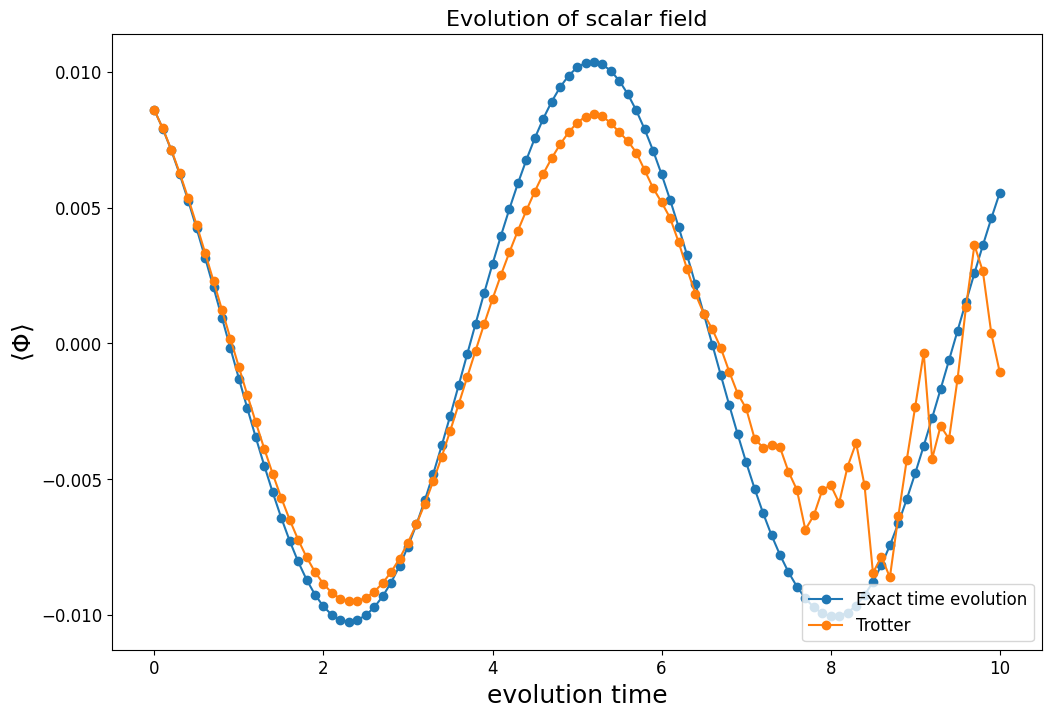

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 8)
plt.plot(ts, np.array(exact_phi_exp_val), "-o", label="Exact time evolution")
plt.plot(ts, np.array(trotter_phi_exp_val), "-o", label="Trotter")
plt.xlabel("evolution time", size=18)
plt.ylabel("$\\langle \\Phi \\rangle$", size=18)
plt.tick_params("both", labelsize=12)
plt.title("Evolution of scalar field", size=16)
plt.legend(fontsize=12, loc="lower right")
plt.show()


Here, we can see the that the exact time evolution curve suggests that the field operator oscillates around 0 with a small amplitude. The Trotter time evolution closely mimics the exact time evolution when the evolution time is small. After $t \geq 7$, the Trotter line behaves irregularly because the Trotter error begins to dominate. This can be fixed by using higher Trotter steps but comes at a price of deeper circuit, where noise from the quantum computer dominates over.

## Resource estimation

In the previous sections, we used a system of merely 2 sites and 4 qubits per site. While this is laptop-simulatable, it is very far from the realistic case where one would hope to have as many sites as possible and the subspace persite is as many as possible. Although this is not simulatable, we can still do resource estimation on how many resources a large scale simulation would take and how accurate the simulation can be on a given device or error correction architecture. Here, we use QURI VM for this purpose. Now we build a VM for square lattice superconducting NISQ device and another VM for STAR.

### NISQ device

For the square lattice NISQ device, we assume there is a $12 \times 12 = 144$ qubits device with basis gates being (`RZ`, `SqrtX`, `X`, `CNOT`). We further assume the 2-qubit gate error rate being $3 \times 10^{-3}$ and single qubit error rate being $5 \times 10^{-4}$.

In [ ]:
from quri_parts.backend.devices import nisq_spcond_lattice
from quri_parts.backend.units import TimeValue, TimeUnit
from quri_parts.circuit.topology.square_lattice import SquareLattice
from quri_vm import VM

square_lattice = SquareLattice(12, 12)

nisq_property = nisq_spcond_lattice.generate_device_property(
    lattice=square_lattice,
    native_gates_1q=("RZ", "SqrtX", "X"),
    native_gates_2q=("CNOT",),
    gate_error_1q=5e-4,
    gate_error_2q=3e-3,
    gate_error_meas=2e-2,
    gate_time_1q=TimeValue(60, TimeUnit.NANOSECOND),
    gate_time_2q=TimeValue(660, TimeUnit.NANOSECOND),
    gate_time_meas=TimeValue(1.4, TimeUnit.MICROSECOND)
)

nisq_vm = VM.from_device_prop(nisq_property)

### Partial error correction device: STAR architecture

Now, we build a VM for an error correction device based on the STAR architecture. This is a partial error correcting architecture introduced in [3]. We assume only 50 qubits are available to us, the code distance is 9 and the physical error rate is $p_{phys} = 10^{-4}$. The basis gates are `CNOT`, `RZ`, `H` and `S`, where the Clifford gates `CNOT`, `H` and `S` are fully error corrections and the `RZ` gate is subjected to logical error rate of:

$$P = 1 - \left(1 - \frac{2p_{phys}}{15}\right)^2.$$

In [ ]:
from quri_parts.backend.devices import star_device

logical_qubit_count = 50
p_phys = 1e-4
star_property = star_device.generate_device_property(
    logical_qubit_count,
    code_distance=9,
    qec_cycle=TimeValue(1, TimeUnit.MICROSECOND),
    physical_error_rate=p_phys
)
star_vm = VM.from_device_prop(star_property)

We first estimate the number of physical qubits needed to implement such device.

In [ ]:
print(f"{star_property.physical_qubit_count} physical qubits used to implement a device of 50 logical qubits and code distance 9.")

32400 physical qubits used to implement a device of 50 logical qubits and code distance 9.


### Resourse estimation: small scale 

Here, we evaluate the circuit execution time and circuit fidelity of the both the state preparation circuit and the time evolution circuit for the 8-qubit system used through out the previous sections.


#### State preparation

First, we start with the state preparation circuit. Recall that we used the 2-layer hardware efficient ansatz to perform the VQE computation. The 2-qubit gates in the hardware efficient ansatz only act on adjacent qubits, so is suitable to be executed on NISQ devices.

In [ ]:
from pprint import pprint

print("NISQ device analysis")
pprint(nisq_state_prep := nisq_vm.analyze(init_state_circuit))

print("----------------------------------------------------------------------------------")
print("STAR device analysis")
pprint(star_state_prep := star_vm.analyze(init_state_circuit))

NISQ device analysis
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=8,
              gate_count=276,
              depth=51,
              latency=TimeValue(value=5460.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.8452801913024685)
----------------------------------------------------------------------------------
STAR device analysis
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=8,
              gate_count=204,
              depth=30,
              latency=TimeValue(value=747000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9986859607354742)


As we can see above, the fidelity of the state preparation circuit on the NISQ device is about 84%, so we can expect the state preparation to be quite accurate even on today's devices with suitable error mitigation. For the STAR architecture, the circuit fidelity reaches fidelity over 99%. However, it comes at a price of execution time over 100 times. While execution time of a single circuit takes merely about 0.7 microseconds, the time of running the whole VQE loop will be magnified, which we will now estimate.

Recall that each call to the cost function involves 2 circuit execution, one pure 4-qubit hardware effecient circuit and the other 4-qubit hardware effecient circuit extended with an $F^{\dagger}$ operation.

In [ ]:
def estimate_vqe_time(
    vm: VM, system: DiscreteScalarField1D, vqe_result: OptimizerState, n_shots_per_iter: int
) -> tuple[TimeValue, float, float]:
    vqe_circuit = HardwareEfficient(system.n_phi_qubit, n_layers)
    conj_momentum_vqe_circuit = vqe_circuit + create_F_gate(system.n_phi_qubit)

    phi_analysis = vm.analyze(vqe_circuit)
    pi_analysis = vm.analyze(conj_momentum_vqe_circuit)

    one_call_time = phi_analysis.latency.in_ns() + pi_analysis.latency.in_ns()

    return (
        TimeValue(one_call_time * vqe_result.funcalls * 1e-9 * n_shots_per_iter, TimeUnit.SECOND),
        phi_analysis.fidelity,
        pi_analysis.fidelity,
    )

Assuming each iterations take $10^5$ shots

In [ ]:
n_shots = int(1e5)
nisq_vqe_time, nisq_phi_fid, nisq_pi_fid = estimate_vqe_time(nisq_vm, system, opt_result, n_shots)
star_vqe_time, star_phi_fid, star_pi_fid = estimate_vqe_time(star_vm, system, opt_result, n_shots)
print(
    f"""
    VQE takes {nisq_vqe_time.value / 3600: .3f} hours to be executed on NISQ device.
    (|Ψ> fidelity: {nisq_phi_fid}, F†|Ψ> fidelity: {nisq_pi_fid})
    """
)
print(
    f"""
    VQE takes {star_vqe_time.value / 3600: .3f} hours to be executed on STAR device.
    (|Ψ> fidelity: {star_phi_fid}, F†|Ψ> fidelity: {star_pi_fid})
    """
)


    VQE takes  8.680 hours to be executed on NISQ device.
    (|Ψ> fidelity: 0.9417291638110525, F†|Ψ> fidelity: 0.7251360304958961)
    

    VQE takes  155.682 hours to be executed on STAR device.
    (|Ψ> fidelity: 0.9999951651847668, F†|Ψ> fidelity: 0.9993389831048093)
    


Here, we can see that executing VQE on an error corrected device takes almost 20 times longer.

#### Time evolution

Next, we evaluate the time evolution circuit on both NISQ and STAR devices.

In [ ]:
print("NISQ device analysis")
pprint(nisq_vm.analyze(init_state_circuit + trotter_evo_factory(10)))

print("----------------------------------------------------------------------------------")
print("STAR device analysis")
pprint(star_vm.analyze(init_state_circuit + trotter_evo_factory(10)))

NISQ device analysis


AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=8,
              gate_count=7526,
              depth=2793,
              latency=TimeValue(value=1377840.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=2.7299584687467146e-07)
----------------------------------------------------------------------------------
STAR device analysis
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=8,
              gate_count=4344,
              depth=1324,
              latency=TimeValue(value=30807000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9638181279070184)


As shown in the results above, the fidelity of running the time evolution circuit on a NISQ device is close to 0 while the fidelity on STAR device remains over 96%. This gives error corrected device major advantage for simulating the scalar field theory.

### Resource estimation: large scale 

The previous section serves as a toy example of cost estimation. We now move to large scale systems that is not laptop-simulatable and estimate the cost like we did in the last section. We discretize the scalar field to 8 sites and each site contains 6 qubits. This gives as 48 logical qubits in total and is almost the maximal size the STAR device can hold.

In [ ]:
large_system = DiscreteScalarField1D(n_discretize=8, n_phi_qubit=6, mb=1, lam=1)

#### State preparation cost

As in the small scale section, we first estimate the fidelity and execution time of the initial state circuit and estimate the cost of executing VQE.

In [ ]:
large_vqe_ansatz = HardwareEfficient(large_system.n_phi_qubit, reps=2)
large_vqe_circuit = large_vqe_ansatz.bind_parameters(np.random.random(large_vqe_ansatz.parameter_count))

large_init_circuit = QuantumCircuit(large_system.n_state_qubit)
for site in range(large_system.n_discretize):
    shift = site * large_system.n_phi_qubit
    large_init_circuit.extend(shift_state_circuit(large_vqe_circuit, shift).gates)

large_init_circuit

In [ ]:
pprint("NISQ device analysis")
pprint(nisq_vm.analyze(large_init_circuit))

print("----------------------------------------------------------------------------------")
pprint("STAR device analysis")
pprint(star_vm.analyze(large_init_circuit))

'NISQ device analysis'
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=48,
              gate_count=1776,
              depth=51,
              latency=TimeValue(value=5460.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.3366966870560188)
----------------------------------------------------------------------------------
'STAR device analysis'
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=48,
              gate_count=1248,
              depth=30,
              latency=TimeValue(value=747000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.992141619566363)


Next, we again estimate the cost of running VQE.

In [ ]:
n_shots = int(1e5)
large_nisq_vqe_time, large_nisq_phi_fid, large_nisq_pi_fid = estimate_vqe_time(nisq_vm, large_system, opt_result, n_shots)
large_star_vqe_time, large_star_phi_fid, large_star_pi_fid = estimate_vqe_time(star_vm, large_system, opt_result, n_shots)
print(
    f"""
    VQE takes {large_nisq_vqe_time.value / 3600: .3f} hours to be executed on NISQ device.
    (|Ψ> fidelity: {large_nisq_phi_fid}, F†|Ψ> fidelity: {large_nisq_pi_fid})
    """
)
print(
    f"""
    VQE takes {large_star_vqe_time.value / 3600: .3f} hours to be executed on STAR device.
    (|Ψ> fidelity: {large_star_phi_fid}, F†|Ψ> fidelity: {large_star_pi_fid})
    """
)


    VQE takes  29.680 hours to be executed on NISQ device.
    (|Ψ> fidelity: 0.9047807805707612, F†|Ψ> fidelity: 0.3342067997898359)
    

    VQE takes  215.946 hours to be executed on STAR device.
    (|Ψ> fidelity: 0.999992747785916, F†|Ψ> fidelity: 0.9984874866534053)
    


### Time evolution circuit

Finally, we evaluate the fidelity of the time evolution circuit.

In [ ]:
trotter_step = 10
large_time_evolution_factory = DiscreteScalarFieldTrotterTimeEvoFactory(large_system, trotter_step)
evo_circuit = large_time_evolution_factory(evolution_time=1.0)

In [ ]:
print("NISQ device analysis")
pprint(nisq_vm.analyze(evo_circuit))

print("----------------------------------------------------------------------------------")
print("STAR device analysis")
pprint(star_vm.analyze(evo_circuit))

NISQ device analysis


AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=48,
              gate_count=54180,
              depth=4498,
              latency=TimeValue(value=2287680.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=8.840122815588379e-52)
----------------------------------------------------------------------------------
STAR device analysis


AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=48,
              gate_count=41060,
              depth=3028,
              latency=TimeValue(value=69984000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.6885154917215952)


This shows that simulating a 48 qubit time evolution with Trotterization is practically impossible, and we need to resort to an error correcting device for better fidelity.

## Hilbert-Schmidt test

While the field operator expectation value for short evolution times closely follows the exact time evolution as seen above, we can confirm that the time-evolution operator as a whole is faithful to this behaviour by evaluating the Hilbert-Schmidt test

$$
    C_\textup{HST}(U,V) = 1 - \frac{1}{4^{N_q}} |\textup{Tr}[U^\dagger V]|^2.
$$

The rightmost term above, the Hilbert-Schmidt product, is equivalent to the average fidelity of two copies of a Haar random state undergoing unitary rotation by $U$ and $V$.

QURI Algo let's us do this with ease. What we need is to import the `HilberSchmidtTest` class from `quri_algo.core.cost_functions` module

In [ ]:
import tqdm
from quri_algo.core.cost_functions import HilbertSchmidtTest

hs_test = HilbertSchmidtTest(
    estimator, alpha=1.0  # This alpha interpolates between the local and global HS tests
)
lhs_test = HilbertSchmidtTest(
    estimator, alpha=0.0
)

ts = np.linspace(0, 10, 101)
hs_cost = []
lhs_cost = []

for t in tqdm.tqdm(ts):
    trotter_evo = trotter_evo_factory(t)
    trotter_state = INIT_STATE.with_gates_applied(trotter_evo)

    exact_evo = exact_evo_factory(t)
    exact_state = INIT_STATE.with_gates_applied(exact_evo)

    hs_cost.append(hs_test(exact_state.circuit, trotter_state.circuit).value.real)
    lhs_cost.append(lhs_test(exact_state.circuit, trotter_state.circuit).value.real)


  0%|          | 0/101 [00:00<?, ?it/s]


  1%|          | 1/101 [00:03<05:13,  3.14s/it]


  2%|▏         | 2/101 [00:05<04:30,  2.73s/it]


  3%|▎         | 3/101 [00:07<04:12,  2.58s/it]


  4%|▍         | 4/101 [00:10<03:59,  2.47s/it]


  5%|▍         | 5/101 [00:12<03:52,  2.43s/it]


  6%|▌         | 6/101 [00:14<03:45,  2.37s/it]


  7%|▋         | 7/101 [00:17<03:52,  2.47s/it]


  8%|▊         | 8/101 [00:19<03:47,  2.44s/it]


  9%|▉         | 9/101 [00:22<03:43,  2.43s/it]


 10%|▉         | 10/101 [00:24<03:37,  2.40s/it]


 11%|█         | 11/101 [00:27<03:36,  2.40s/it]


 12%|█▏        | 12/101 [00:29<03:41,  2.49s/it]


 13%|█▎        | 13/101 [00:32<03:33,  2.42s/it]


 14%|█▍        | 14/101 [00:34<03:25,  2.36s/it]


 15%|█▍        | 15/101 [00:36<03:21,  2.35s/it]


 16%|█▌        | 16/101 [00:38<03:17,  2.32s/it]


 17%|█▋        | 17/101 [00:41<03:27,  2.47s/it]


 18%|█▊        | 18/101 [00:43<03:19,  2.40s/it]


 19%|█▉        | 19/101 [00:46<03:15,  2.39s/it]


 20%|█▉        | 20/101 [00:48<03:11,  2.37s/it]


 21%|██        | 21/101 [00:50<03:09,  2.37s/it]


 22%|██▏       | 22/101 [00:53<03:14,  2.46s/it]


 23%|██▎       | 23/101 [00:56<03:10,  2.44s/it]


 24%|██▍       | 24/101 [00:58<03:04,  2.40s/it]


 25%|██▍       | 25/101 [01:00<03:00,  2.37s/it]


 26%|██▌       | 26/101 [01:02<02:54,  2.33s/it]


 27%|██▋       | 27/101 [01:05<03:00,  2.44s/it]


 28%|██▊       | 28/101 [01:07<02:56,  2.42s/it]


 29%|██▊       | 29/101 [01:10<02:53,  2.40s/it]


 30%|██▉       | 30/101 [01:12<02:50,  2.41s/it]


 31%|███       | 31/101 [01:15<02:47,  2.40s/it]


 32%|███▏      | 32/101 [01:17<02:52,  2.50s/it]


 33%|███▎      | 33/101 [01:20<02:48,  2.48s/it]


 34%|███▎      | 34/101 [01:22<02:41,  2.41s/it]


 35%|███▍      | 35/101 [01:24<02:37,  2.39s/it]


 36%|███▌      | 36/101 [01:27<02:31,  2.33s/it]


 37%|███▋      | 37/101 [01:29<02:38,  2.48s/it]


 38%|███▊      | 38/101 [01:32<02:35,  2.47s/it]


 39%|███▊      | 39/101 [01:34<02:31,  2.45s/it]


 40%|███▉      | 40/101 [01:36<02:26,  2.40s/it]


 41%|████      | 41/101 [01:39<02:24,  2.41s/it]


 42%|████▏     | 42/101 [01:42<02:29,  2.53s/it]


 43%|████▎     | 43/101 [01:44<02:25,  2.51s/it]


 44%|████▎     | 44/101 [01:47<02:22,  2.49s/it]


 45%|████▍     | 45/101 [01:49<02:17,  2.46s/it]


 46%|████▌     | 46/101 [01:51<02:14,  2.44s/it]


 47%|████▋     | 47/101 [01:54<02:16,  2.52s/it]


 48%|████▊     | 48/101 [01:56<02:10,  2.47s/it]


 49%|████▊     | 49/101 [01:59<02:05,  2.41s/it]


 50%|████▉     | 50/101 [02:01<02:02,  2.40s/it]


 50%|█████     | 51/101 [02:04<02:03,  2.47s/it]


 51%|█████▏    | 52/101 [02:06<01:57,  2.40s/it]


 52%|█████▏    | 53/101 [02:08<01:54,  2.39s/it]


 53%|█████▎    | 54/101 [02:11<01:52,  2.39s/it]


 54%|█████▍    | 55/101 [02:13<01:50,  2.40s/it]


 55%|█████▌    | 56/101 [02:16<01:51,  2.48s/it]


 56%|█████▋    | 57/101 [02:18<01:47,  2.44s/it]


 57%|█████▋    | 58/101 [02:21<01:43,  2.41s/it]


 58%|█████▊    | 59/101 [02:23<01:40,  2.39s/it]


 59%|█████▉    | 60/101 [02:25<01:37,  2.37s/it]


 60%|██████    | 61/101 [02:28<01:38,  2.45s/it]


 61%|██████▏   | 62/101 [02:30<01:34,  2.41s/it]


 62%|██████▏   | 63/101 [02:33<01:31,  2.40s/it]


 63%|██████▎   | 64/101 [02:35<01:28,  2.38s/it]


 64%|██████▍   | 65/101 [02:37<01:28,  2.45s/it]


 65%|██████▌   | 66/101 [02:40<01:29,  2.54s/it]


 66%|██████▋   | 67/101 [02:43<01:24,  2.48s/it]


 67%|██████▋   | 68/101 [02:45<01:21,  2.47s/it]


 68%|██████▊   | 69/101 [02:47<01:17,  2.43s/it]


 69%|██████▉   | 70/101 [02:50<01:15,  2.43s/it]


 70%|███████   | 71/101 [02:53<01:16,  2.54s/it]


 71%|███████▏  | 72/101 [02:55<01:11,  2.48s/it]


 72%|███████▏  | 73/101 [02:57<01:08,  2.45s/it]


 73%|███████▎  | 74/101 [03:00<01:05,  2.43s/it]


 74%|███████▍  | 75/101 [03:02<01:04,  2.48s/it]


 75%|███████▌  | 76/101 [03:06<01:10,  2.81s/it]


 76%|███████▌  | 77/101 [03:10<01:15,  3.16s/it]


 77%|███████▋  | 78/101 [03:13<01:15,  3.30s/it]


 78%|███████▊  | 79/101 [03:16<01:08,  3.13s/it]


 79%|███████▉  | 80/101 [03:19<01:00,  2.90s/it]


 80%|████████  | 81/101 [03:21<00:56,  2.83s/it]


 81%|████████  | 82/101 [03:24<00:50,  2.66s/it]


 82%|████████▏ | 83/101 [03:26<00:45,  2.55s/it]


 83%|████████▎ | 84/101 [03:28<00:42,  2.48s/it]


 84%|████████▍ | 85/101 [03:30<00:38,  2.42s/it]


 85%|████████▌ | 86/101 [03:33<00:37,  2.52s/it]


 86%|████████▌ | 87/101 [03:36<00:36,  2.64s/it]


 87%|████████▋ | 88/101 [03:39<00:33,  2.61s/it]


 88%|████████▊ | 89/101 [03:41<00:31,  2.60s/it]


 89%|████████▉ | 90/101 [03:44<00:29,  2.69s/it]


 90%|█████████ | 91/101 [03:47<00:27,  2.77s/it]


 91%|█████████ | 92/101 [03:50<00:24,  2.70s/it]


 92%|█████████▏| 93/101 [03:52<00:20,  2.59s/it]


 93%|█████████▎| 94/101 [03:54<00:17,  2.56s/it]


 94%|█████████▍| 95/101 [03:57<00:15,  2.51s/it]


 95%|█████████▌| 96/101 [04:00<00:12,  2.59s/it]


 96%|█████████▌| 97/101 [04:02<00:10,  2.53s/it]


 97%|█████████▋| 98/101 [04:04<00:07,  2.46s/it]


 98%|█████████▊| 99/101 [04:07<00:04,  2.42s/it]


 99%|█████████▉| 100/101 [04:09<00:02,  2.43s/it]


100%|██████████| 101/101 [04:12<00:00,  2.59s/it]


100%|██████████| 101/101 [04:12<00:00,  2.50s/it]

We will plot the cost-function below for each time-step

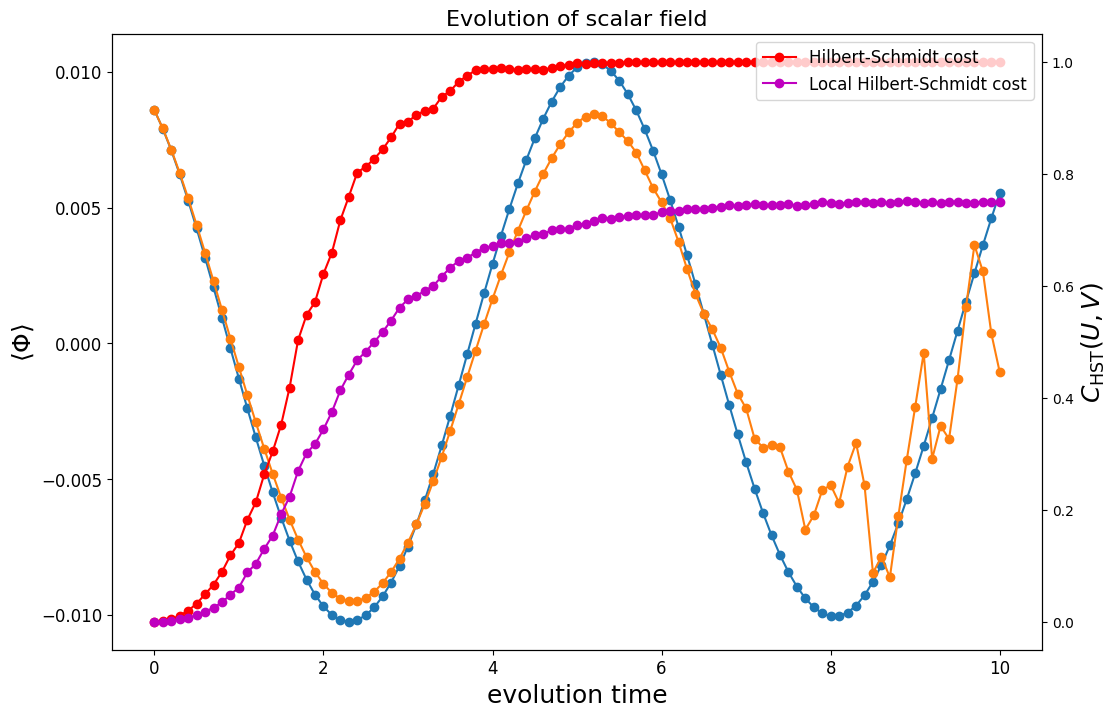

In [ ]:

plt.rcParams["figure.figsize"] = (12, 8)
plt.plot(ts, np.array(exact_phi_exp_val), "-o", label="Exact time evolution")
plt.plot(ts, np.array(trotter_phi_exp_val), "-o", label="Trotter")
plt.xlabel("evolution time", size=18)
plt.ylabel("$\\langle \\Phi \\rangle$", size=18)
plt.tick_params("both", labelsize=12)
plt.title("Evolution of scalar field", size=16)
plt.twinx()
plt.plot(ts, np.array(hs_cost), "-or", label="Hilbert-Schmidt cost")
plt.plot(ts, np.array(lhs_cost), "-om", label="Local Hilbert-Schmidt cost")
plt.ylabel("$C_\\text{HST}(U,V)$", size=18)
plt.legend(fontsize=12, loc="upper right")
plt.show()

Evidently, the fidelity of two unitaries is a much stricter condition for accurate time-evolution compared to the operator expectation value - and this makes sense since the expectation value of a quantum operator with respect to a pure state is only sensitive to a single state, whereas the Hilbert-Schmidt product is a state averaged quantity over the whole Hilbert space!

Does the situation change if we use the local Hilbert-Schmidt test? Well, to some extent the local Hilbert-Schmidt cost is lower. This is because it is an average over local cost-functions that each only depend on the resulting density matrix of a single pair of qubits. Here each of these local cost functions measure whether those qubit pairs can be disentangled or by a local operation. This defines the entanglement fidelity, which is weighted equally for each pair. In contrast, for the global Hilbert-Schmidt cost to be significantly lower than unity every qubit pair must simultaneously be disentangled.

The main take-away is that the two cost-functions, the local and the global Hilbert-Schmidt tests in general do not have the same inflection point, and in general for larger systems the local Hilbert Schmidt test will be smoother, whereas the Hilbert-Schmidt product for the global one will be exponentially suppressed. Thus for larger qubit systems the local one is preferred as it is more likely to have non-zero gradients when used as a cost-function

### Can we improve it by adding more Trotter steps?

Let's try with more Trotter steps and see if the situation improves. We will add several Trotter steps below and evaluate the Hilbert-Schmidt cost of each circuit. For the evaluation we will compare with the exact time-evolution unitary.

In [ ]:

trotter_steps = [20, 30, 40, 50, 60]
exact_evo_factory = DiscreteScalarFieldExactTimeEvoFactory(system)

hs_cost_lists= []

for i, n_trotter in enumerate(tqdm.tqdm(trotter_steps)):
    trotter_evo_factory = DiscreteScalarFieldTrotterTimeEvoFactory(system, n_trotter)
    hs_cost_lists.append([])
    for t in tqdm.tqdm(ts):
        trotter_evo = trotter_evo_factory(t)
        trotter_state = INIT_STATE.with_gates_applied(trotter_evo)

        exact_evo = exact_evo_factory(t)
        exact_state = INIT_STATE.with_gates_applied(exact_evo)

        hs_cost_lists[i].append(hs_test(exact_state.circuit, trotter_state.circuit).value.real)


  0%|          | 0/5 [00:00<?, ?it/s]


  0%|          | 0/101 [00:00<?, ?it/s]


  1%|          | 1/101 [00:02<03:57,  2.37s/it]


  2%|▏         | 2/101 [00:04<03:59,  2.42s/it]


  3%|▎         | 3/101 [00:07<04:00,  2.46s/it]


  4%|▍         | 4/101 [00:09<03:58,  2.46s/it]


  5%|▍         | 5/101 [00:12<04:13,  2.64s/it]


  6%|▌         | 6/101 [00:15<04:10,  2.64s/it]


  7%|▋         | 7/101 [00:18<04:07,  2.63s/it]


  8%|▊         | 8/101 [00:20<04:00,  2.59s/it]


  9%|▉         | 9/101 [00:22<03:54,  2.55s/it]


 10%|▉         | 10/101 [00:25<04:01,  2.65s/it]


 11%|█         | 11/101 [00:28<03:55,  2.62s/it]


 12%|█▏        | 12/101 [00:30<03:49,  2.58s/it]


 13%|█▎        | 13/101 [00:33<03:44,  2.55s/it]


 14%|█▍        | 14/101 [00:35<03:41,  2.54s/it]


 15%|█▍        | 15/101 [00:38<03:52,  2.70s/it]


 16%|█▌        | 16/101 [00:41<03:46,  2.66s/it]


 17%|█▋        | 17/101 [00:44<03:47,  2.70s/it]


 18%|█▊        | 18/101 [00:47<03:45,  2.72s/it]


 19%|█▉        | 19/101 [00:50<03:49,  2.79s/it]


 20%|█▉        | 20/101 [00:53<03:57,  2.93s/it]


 21%|██        | 21/101 [00:55<03:48,  2.85s/it]


 22%|██▏       | 22/101 [00:58<03:44,  2.84s/it]


 23%|██▎       | 23/101 [01:01<03:36,  2.78s/it]


 24%|██▍       | 24/101 [01:04<03:38,  2.83s/it]


 25%|██▍       | 25/101 [01:07<03:42,  2.92s/it]


 26%|██▌       | 26/101 [01:10<03:29,  2.80s/it]


 27%|██▋       | 27/101 [01:12<03:20,  2.71s/it]


 28%|██▊       | 28/101 [01:15<03:13,  2.65s/it]


 29%|██▊       | 29/101 [01:18<03:18,  2.76s/it]


 30%|██▉       | 30/101 [01:20<03:12,  2.71s/it]


 31%|███       | 31/101 [01:23<03:06,  2.67s/it]


 32%|███▏      | 32/101 [01:25<03:05,  2.68s/it]


 33%|███▎      | 33/101 [01:28<02:59,  2.64s/it]


 34%|███▎      | 34/101 [01:31<02:55,  2.61s/it]


 35%|███▍      | 35/101 [01:33<02:57,  2.69s/it]


 36%|███▌      | 36/101 [01:36<02:50,  2.63s/it]


 37%|███▋      | 37/101 [01:39<02:53,  2.71s/it]


 38%|███▊      | 38/101 [01:42<02:54,  2.77s/it]


 39%|███▊      | 39/101 [01:45<02:53,  2.80s/it]


 40%|███▉      | 40/101 [01:48<02:59,  2.94s/it]


 41%|████      | 41/101 [01:50<02:48,  2.81s/it]


 42%|████▏     | 42/101 [01:53<02:44,  2.78s/it]


 43%|████▎     | 43/101 [01:55<02:33,  2.65s/it]


 44%|████▎     | 44/101 [01:59<02:40,  2.81s/it]


 45%|████▍     | 45/101 [02:01<02:33,  2.75s/it]


 46%|████▌     | 46/101 [02:04<02:26,  2.67s/it]


 47%|████▋     | 47/101 [02:06<02:20,  2.61s/it]


 48%|████▊     | 48/101 [02:09<02:14,  2.54s/it]


 49%|████▊     | 49/101 [02:12<02:21,  2.72s/it]


 50%|████▉     | 50/101 [02:14<02:15,  2.65s/it]


 50%|█████     | 51/101 [02:17<02:12,  2.66s/it]


 51%|█████▏    | 52/101 [02:20<02:10,  2.67s/it]


 52%|█████▏    | 53/101 [02:22<02:06,  2.64s/it]


 53%|█████▎    | 54/101 [02:25<02:10,  2.77s/it]


 54%|█████▍    | 55/101 [02:28<02:07,  2.77s/it]


 55%|█████▌    | 56/101 [02:30<02:01,  2.69s/it]


 56%|█████▋    | 57/101 [02:33<01:57,  2.66s/it]


 57%|█████▋    | 58/101 [02:36<01:55,  2.68s/it]


 58%|█████▊    | 59/101 [02:39<01:58,  2.81s/it]


 59%|█████▉    | 60/101 [02:42<01:52,  2.76s/it]


 60%|██████    | 61/101 [02:44<01:50,  2.76s/it]


 61%|██████▏   | 62/101 [02:48<01:57,  3.00s/it]


 62%|██████▏   | 63/101 [02:52<02:11,  3.45s/it]


 63%|██████▎   | 64/101 [02:55<02:03,  3.35s/it]


 64%|██████▍   | 65/101 [02:59<01:57,  3.28s/it]


 65%|██████▌   | 66/101 [03:01<01:47,  3.07s/it]


 66%|██████▋   | 67/101 [03:04<01:39,  2.93s/it]


 67%|██████▋   | 68/101 [03:06<01:33,  2.82s/it]


 68%|██████▊   | 69/101 [03:09<01:31,  2.87s/it]


 69%|██████▉   | 70/101 [03:12<01:26,  2.80s/it]


 70%|███████   | 71/101 [03:15<01:22,  2.76s/it]


 71%|███████▏  | 72/101 [03:17<01:16,  2.64s/it]


 72%|███████▏  | 73/101 [03:20<01:17,  2.75s/it]


 73%|███████▎  | 74/101 [03:22<01:12,  2.67s/it]


 74%|███████▍  | 75/101 [03:25<01:08,  2.64s/it]


 75%|███████▌  | 76/101 [03:27<01:04,  2.59s/it]


 76%|███████▌  | 77/101 [03:30<01:01,  2.57s/it]


 77%|███████▋  | 78/101 [03:33<01:01,  2.69s/it]


 78%|███████▊  | 79/101 [03:35<00:57,  2.61s/it]


 79%|███████▉  | 80/101 [03:38<00:53,  2.57s/it]


 80%|████████  | 81/101 [03:40<00:50,  2.53s/it]


 81%|████████  | 82/101 [03:43<00:48,  2.53s/it]


 82%|████████▏ | 83/101 [03:46<00:47,  2.63s/it]


 83%|████████▎ | 84/101 [03:48<00:43,  2.58s/it]


 84%|████████▍ | 85/101 [03:51<00:40,  2.55s/it]


 85%|████████▌ | 86/101 [03:53<00:37,  2.52s/it]


 86%|████████▌ | 87/101 [03:56<00:35,  2.50s/it]


 87%|████████▋ | 88/101 [03:59<00:35,  2.71s/it]


 88%|████████▊ | 89/101 [04:01<00:31,  2.63s/it]


 89%|████████▉ | 90/101 [04:04<00:28,  2.63s/it]


 90%|█████████ | 91/101 [04:06<00:26,  2.61s/it]


 91%|█████████ | 92/101 [04:09<00:23,  2.59s/it]


 92%|█████████▏| 93/101 [04:12<00:21,  2.74s/it]


 93%|█████████▎| 94/101 [04:15<00:18,  2.70s/it]


 94%|█████████▍| 95/101 [04:17<00:16,  2.73s/it]


 95%|█████████▌| 96/101 [04:20<00:13,  2.70s/it]


 96%|█████████▌| 97/101 [04:23<00:10,  2.67s/it]


 97%|█████████▋| 98/101 [04:26<00:08,  2.77s/it]


 98%|█████████▊| 99/101 [04:28<00:05,  2.70s/it]


 99%|█████████▉| 100/101 [04:31<00:02,  2.68s/it]


100%|██████████| 101/101 [04:33<00:00,  2.65s/it]


100%|██████████| 101/101 [04:33<00:00,  2.71s/it]



 20%|██        | 1/5 [04:33<18:15, 273.95s/it]


  0%|          | 0/101 [00:00<?, ?it/s]


  1%|          | 1/101 [00:02<03:59,  2.40s/it]


  2%|▏         | 2/101 [00:05<04:41,  2.85s/it]


  3%|▎         | 3/101 [00:08<04:28,  2.74s/it]


  4%|▍         | 4/101 [00:10<04:19,  2.68s/it]


  5%|▍         | 5/101 [00:13<04:20,  2.71s/it]


  6%|▌         | 6/101 [00:16<04:24,  2.79s/it]


  7%|▋         | 7/101 [00:19<04:22,  2.80s/it]


  8%|▊         | 8/101 [00:22<04:30,  2.91s/it]


  9%|▉         | 9/101 [00:25<04:20,  2.83s/it]


 10%|▉         | 10/101 [00:27<04:18,  2.84s/it]


 11%|█         | 11/101 [00:30<04:10,  2.78s/it]


 12%|█▏        | 12/101 [00:33<04:12,  2.84s/it]


 13%|█▎        | 13/101 [00:36<04:05,  2.79s/it]


 14%|█▍        | 14/101 [00:38<03:56,  2.72s/it]


 15%|█▍        | 15/101 [00:41<03:55,  2.74s/it]


 16%|█▌        | 16/101 [00:44<03:47,  2.68s/it]


 17%|█▋        | 17/101 [00:47<03:53,  2.78s/it]


 18%|█▊        | 18/101 [00:49<03:44,  2.71s/it]


 19%|█▉        | 19/101 [00:52<03:41,  2.70s/it]


 20%|█▉        | 20/101 [00:54<03:36,  2.67s/it]


 21%|██        | 21/101 [00:57<03:29,  2.62s/it]


 22%|██▏       | 22/101 [01:00<03:40,  2.79s/it]


 23%|██▎       | 23/101 [01:03<03:34,  2.75s/it]


 24%|██▍       | 24/101 [01:06<03:31,  2.74s/it]


 25%|██▍       | 25/101 [01:08<03:26,  2.72s/it]


 26%|██▌       | 26/101 [01:11<03:18,  2.65s/it]


 27%|██▋       | 27/101 [01:14<03:24,  2.76s/it]


 28%|██▊       | 28/101 [01:16<03:17,  2.70s/it]


 29%|██▊       | 29/101 [01:19<03:13,  2.69s/it]


 30%|██▉       | 30/101 [01:22<03:10,  2.68s/it]


 31%|███       | 31/101 [01:24<03:05,  2.65s/it]


 32%|███▏      | 32/101 [01:27<03:10,  2.76s/it]


 33%|███▎      | 33/101 [01:30<03:04,  2.71s/it]


 34%|███▎      | 34/101 [01:32<02:57,  2.65s/it]


 35%|███▍      | 35/101 [01:35<02:54,  2.64s/it]


 36%|███▌      | 36/101 [01:38<02:51,  2.63s/it]


 37%|███▋      | 37/101 [01:41<02:56,  2.76s/it]


 38%|███▊      | 38/101 [01:43<02:51,  2.72s/it]


 39%|███▊      | 39/101 [01:46<02:46,  2.68s/it]


 40%|███▉      | 40/101 [01:48<02:43,  2.67s/it]


 41%|████      | 41/101 [01:51<02:38,  2.64s/it]


 42%|████▏     | 42/101 [01:54<02:41,  2.74s/it]


 43%|████▎     | 43/101 [01:57<02:35,  2.68s/it]


 44%|████▎     | 44/101 [01:59<02:29,  2.63s/it]


 45%|████▍     | 45/101 [02:02<02:27,  2.63s/it]


 46%|████▌     | 46/101 [02:04<02:25,  2.65s/it]


 47%|████▋     | 47/101 [02:07<02:26,  2.71s/it]


 48%|████▊     | 48/101 [02:10<02:22,  2.68s/it]


 49%|████▊     | 49/101 [02:13<02:19,  2.68s/it]


 50%|████▉     | 50/101 [02:15<02:13,  2.61s/it]


 50%|█████     | 51/101 [02:18<02:15,  2.71s/it]


 51%|█████▏    | 52/101 [02:21<02:11,  2.68s/it]


 52%|█████▏    | 53/101 [02:23<02:06,  2.63s/it]


 53%|█████▎    | 54/101 [02:26<02:03,  2.62s/it]


 54%|█████▍    | 55/101 [02:28<02:01,  2.64s/it]


 55%|█████▌    | 56/101 [02:31<02:05,  2.79s/it]


 56%|█████▋    | 57/101 [02:34<02:02,  2.78s/it]


 57%|█████▋    | 58/101 [02:37<02:02,  2.84s/it]


 58%|█████▊    | 59/101 [02:40<01:58,  2.81s/it]


 59%|█████▉    | 60/101 [02:43<01:53,  2.78s/it]


 60%|██████    | 61/101 [02:46<01:55,  2.89s/it]


 61%|██████▏   | 62/101 [02:48<01:48,  2.79s/it]


 62%|██████▏   | 63/101 [02:51<01:44,  2.76s/it]


 63%|██████▎   | 64/101 [02:54<01:40,  2.71s/it]


 64%|██████▍   | 65/101 [02:56<01:37,  2.72s/it]


 65%|██████▌   | 66/101 [02:59<01:37,  2.80s/it]


 66%|██████▋   | 67/101 [03:02<01:32,  2.72s/it]


 67%|██████▋   | 68/101 [03:04<01:27,  2.65s/it]


 68%|██████▊   | 69/101 [03:07<01:25,  2.67s/it]


 69%|██████▉   | 70/101 [03:10<01:21,  2.63s/it]


 70%|███████   | 71/101 [03:13<01:22,  2.74s/it]


 71%|███████▏  | 72/101 [03:15<01:18,  2.71s/it]


 72%|███████▏  | 73/101 [03:18<01:15,  2.69s/it]


 73%|███████▎  | 74/101 [03:20<01:11,  2.65s/it]


 74%|███████▍  | 75/101 [03:23<01:08,  2.65s/it]


 75%|███████▌  | 76/101 [03:26<01:08,  2.75s/it]


 76%|███████▌  | 77/101 [03:29<01:04,  2.70s/it]


 77%|███████▋  | 78/101 [03:31<01:01,  2.69s/it]


 78%|███████▊  | 79/101 [03:34<00:58,  2.65s/it]


 79%|███████▉  | 80/101 [03:36<00:54,  2.60s/it]


 80%|████████  | 81/101 [03:39<00:55,  2.76s/it]


 81%|████████  | 82/101 [03:42<00:50,  2.68s/it]


 82%|████████▏ | 83/101 [03:45<00:47,  2.66s/it]


 83%|████████▎ | 84/101 [03:47<00:45,  2.66s/it]


 84%|████████▍ | 85/101 [03:50<00:42,  2.64s/it]


 85%|████████▌ | 86/101 [03:53<00:41,  2.75s/it]


 86%|████████▌ | 87/101 [03:55<00:37,  2.68s/it]


 87%|████████▋ | 88/101 [03:58<00:34,  2.64s/it]


 88%|████████▊ | 89/101 [04:01<00:31,  2.64s/it]


 89%|████████▉ | 90/101 [04:03<00:29,  2.65s/it]


 90%|█████████ | 91/101 [04:06<00:27,  2.75s/it]


 91%|█████████ | 92/101 [04:09<00:24,  2.71s/it]


 92%|█████████▏| 93/101 [04:12<00:21,  2.70s/it]


 93%|█████████▎| 94/101 [04:14<00:18,  2.66s/it]


 94%|█████████▍| 95/101 [04:17<00:15,  2.62s/it]


 95%|█████████▌| 96/101 [04:20<00:13,  2.74s/it]


 96%|█████████▌| 97/101 [04:22<00:10,  2.69s/it]


 97%|█████████▋| 98/101 [04:25<00:08,  2.67s/it]


 98%|█████████▊| 99/101 [04:27<00:05,  2.64s/it]


 99%|█████████▉| 100/101 [04:30<00:02,  2.62s/it]


100%|██████████| 101/101 [04:33<00:00,  2.72s/it]


100%|██████████| 101/101 [04:33<00:00,  2.71s/it]



 40%|████      | 2/5 [09:07<13:41, 273.69s/it]


  0%|          | 0/101 [00:00<?, ?it/s]


  1%|          | 1/101 [00:02<04:06,  2.46s/it]


  2%|▏         | 2/101 [00:05<04:11,  2.54s/it]


  3%|▎         | 3/101 [00:07<04:13,  2.59s/it]


  4%|▍         | 4/101 [00:10<04:16,  2.64s/it]


  5%|▍         | 5/101 [00:13<04:30,  2.82s/it]


  6%|▌         | 6/101 [00:16<04:26,  2.81s/it]


  7%|▋         | 7/101 [00:19<04:21,  2.78s/it]


  8%|▊         | 8/101 [00:21<04:16,  2.75s/it]


  9%|▉         | 9/101 [00:24<04:11,  2.73s/it]


 10%|▉         | 10/101 [00:27<04:19,  2.85s/it]


 11%|█         | 11/101 [00:30<04:10,  2.78s/it]


 12%|█▏        | 12/101 [00:32<04:07,  2.78s/it]


 13%|█▎        | 13/101 [00:35<04:02,  2.75s/it]


 14%|█▍        | 14/101 [00:38<03:58,  2.74s/it]


 15%|█▍        | 15/101 [00:41<04:04,  2.84s/it]


 16%|█▌        | 16/101 [00:44<03:54,  2.76s/it]


 17%|█▋        | 17/101 [00:46<03:47,  2.71s/it]


 18%|█▊        | 18/101 [00:49<03:45,  2.71s/it]


 19%|█▉        | 19/101 [00:51<03:38,  2.67s/it]


 20%|█▉        | 20/101 [00:55<03:46,  2.80s/it]


 21%|██        | 21/101 [00:57<03:42,  2.78s/it]


 22%|██▏       | 22/101 [01:00<03:36,  2.74s/it]


 23%|██▎       | 23/101 [01:03<03:33,  2.74s/it]


 24%|██▍       | 24/101 [01:05<03:30,  2.73s/it]


 25%|██▍       | 25/101 [01:08<03:33,  2.81s/it]


 26%|██▌       | 26/101 [01:11<03:25,  2.74s/it]


 27%|██▋       | 27/101 [01:14<03:21,  2.73s/it]


 28%|██▊       | 28/101 [01:16<03:17,  2.70s/it]


 29%|██▊       | 29/101 [01:19<03:14,  2.70s/it]


 30%|██▉       | 30/101 [01:22<03:25,  2.89s/it]


 31%|███       | 31/101 [01:25<03:26,  2.95s/it]


 32%|███▏      | 32/101 [01:28<03:16,  2.84s/it]


 33%|███▎      | 33/101 [01:31<03:09,  2.79s/it]


 34%|███▎      | 34/101 [01:33<03:01,  2.71s/it]


 35%|███▍      | 35/101 [01:36<03:09,  2.87s/it]


 36%|███▌      | 36/101 [01:39<03:04,  2.84s/it]


 37%|███▋      | 37/101 [01:42<03:00,  2.82s/it]


 38%|███▊      | 38/101 [01:45<02:57,  2.81s/it]


 39%|███▊      | 39/101 [01:47<02:52,  2.78s/it]


 40%|███▉      | 40/101 [01:51<02:56,  2.89s/it]


 41%|████      | 41/101 [01:53<02:50,  2.84s/it]


 42%|████▏     | 42/101 [01:56<02:43,  2.77s/it]


 43%|████▎     | 43/101 [01:59<02:41,  2.78s/it]


 44%|████▎     | 44/101 [02:02<02:45,  2.91s/it]


 45%|████▍     | 45/101 [02:05<02:40,  2.87s/it]


 46%|████▌     | 46/101 [02:07<02:36,  2.84s/it]


 47%|████▋     | 47/101 [02:10<02:30,  2.79s/it]


 48%|████▊     | 48/101 [02:13<02:24,  2.73s/it]


 49%|████▊     | 49/101 [02:16<02:33,  2.96s/it]


 50%|████▉     | 50/101 [02:19<02:25,  2.85s/it]


 50%|█████     | 51/101 [02:22<02:20,  2.80s/it]


 51%|█████▏    | 52/101 [02:24<02:15,  2.77s/it]


 52%|█████▏    | 53/101 [02:27<02:13,  2.77s/it]


 53%|█████▎    | 54/101 [02:30<02:16,  2.90s/it]


 54%|█████▍    | 55/101 [02:33<02:09,  2.81s/it]


 55%|█████▌    | 56/101 [02:36<02:06,  2.80s/it]


 56%|█████▋    | 57/101 [02:38<02:00,  2.74s/it]


 57%|█████▋    | 58/101 [02:41<01:55,  2.68s/it]


 58%|█████▊    | 59/101 [02:44<01:56,  2.78s/it]


 59%|█████▉    | 60/101 [02:46<01:53,  2.76s/it]


 60%|██████    | 61/101 [02:49<01:48,  2.71s/it]


 61%|██████▏   | 62/101 [02:52<01:44,  2.68s/it]


 62%|██████▏   | 63/101 [02:54<01:40,  2.65s/it]


 63%|██████▎   | 64/101 [02:57<01:43,  2.79s/it]


 64%|██████▍   | 65/101 [03:00<01:39,  2.76s/it]


 65%|██████▌   | 66/101 [03:03<01:37,  2.77s/it]


 66%|██████▋   | 67/101 [03:06<01:34,  2.77s/it]


 67%|██████▋   | 68/101 [03:08<01:31,  2.76s/it]


 68%|██████▊   | 69/101 [03:11<01:30,  2.84s/it]


 69%|██████▉   | 70/101 [03:14<01:28,  2.87s/it]


 70%|███████   | 71/101 [03:17<01:25,  2.85s/it]


 71%|███████▏  | 72/101 [03:20<01:22,  2.85s/it]


 72%|███████▏  | 73/101 [03:23<01:18,  2.82s/it]


 73%|███████▎  | 74/101 [03:26<01:18,  2.92s/it]


 74%|███████▍  | 75/101 [03:28<01:13,  2.84s/it]


 75%|███████▌  | 76/101 [03:31<01:09,  2.79s/it]


 76%|███████▌  | 77/101 [03:34<01:06,  2.79s/it]


 77%|███████▋  | 78/101 [03:37<01:04,  2.81s/it]


 78%|███████▊  | 79/101 [03:40<01:03,  2.89s/it]


 79%|███████▉  | 80/101 [03:43<00:59,  2.85s/it]


 80%|████████  | 81/101 [03:45<00:56,  2.83s/it]


 81%|████████  | 82/101 [03:48<00:52,  2.76s/it]


 82%|████████▏ | 83/101 [03:51<00:49,  2.73s/it]


 83%|████████▎ | 84/101 [03:54<00:47,  2.82s/it]


 84%|████████▍ | 85/101 [03:56<00:44,  2.81s/it]


 85%|████████▌ | 86/101 [03:59<00:41,  2.77s/it]


 86%|████████▌ | 87/101 [04:02<00:38,  2.75s/it]


 87%|████████▋ | 88/101 [04:05<00:35,  2.73s/it]


 88%|████████▊ | 89/101 [04:08<00:34,  2.84s/it]


 89%|████████▉ | 90/101 [04:10<00:30,  2.77s/it]


 90%|█████████ | 91/101 [04:13<00:27,  2.71s/it]


 91%|█████████ | 92/101 [04:16<00:24,  2.71s/it]


 92%|█████████▏| 93/101 [04:18<00:21,  2.72s/it]


 93%|█████████▎| 94/101 [04:21<00:19,  2.84s/it]


 94%|█████████▍| 95/101 [04:24<00:16,  2.77s/it]


 95%|█████████▌| 96/101 [04:27<00:13,  2.76s/it]


 96%|█████████▌| 97/101 [04:29<00:10,  2.72s/it]


 97%|█████████▋| 98/101 [04:32<00:08,  2.73s/it]


 98%|█████████▊| 99/101 [04:35<00:05,  2.84s/it]


 99%|█████████▉| 100/101 [04:38<00:02,  2.78s/it]


100%|██████████| 101/101 [04:41<00:00,  2.78s/it]


100%|██████████| 101/101 [04:41<00:00,  2.78s/it]



 60%|██████    | 3/5 [13:48<09:14, 277.17s/it]


  0%|          | 0/101 [00:00<?, ?it/s]


  1%|          | 1/101 [00:02<04:16,  2.57s/it]


  2%|▏         | 2/101 [00:05<04:28,  2.71s/it]


  3%|▎         | 3/101 [00:08<04:45,  2.91s/it]


  4%|▍         | 4/101 [00:11<04:36,  2.85s/it]


  5%|▍         | 5/101 [00:14<04:32,  2.83s/it]


  6%|▌         | 6/101 [00:16<04:22,  2.76s/it]


  7%|▋         | 7/101 [00:19<04:18,  2.75s/it]


  8%|▊         | 8/101 [00:22<04:27,  2.88s/it]


  9%|▉         | 9/101 [00:25<04:17,  2.80s/it]


 10%|▉         | 10/101 [00:28<04:16,  2.82s/it]


 11%|█         | 11/101 [00:30<04:11,  2.80s/it]


 12%|█▏        | 12/101 [00:33<04:10,  2.81s/it]


 13%|█▎        | 13/101 [00:36<04:16,  2.92s/it]


 14%|█▍        | 14/101 [00:39<04:10,  2.88s/it]


 15%|█▍        | 15/101 [00:42<04:03,  2.83s/it]


 16%|█▌        | 16/101 [00:45<03:57,  2.80s/it]


 17%|█▋        | 17/101 [00:47<03:55,  2.80s/it]


 18%|█▊        | 18/101 [00:51<04:01,  2.91s/it]


 19%|█▉        | 19/101 [00:53<03:55,  2.87s/it]


 20%|█▉        | 20/101 [00:56<03:48,  2.82s/it]


 21%|██        | 21/101 [00:59<03:43,  2.80s/it]


 22%|██▏       | 22/101 [01:02<03:39,  2.77s/it]


 23%|██▎       | 23/101 [01:05<03:47,  2.91s/it]


 24%|██▍       | 24/101 [01:07<03:40,  2.86s/it]


 25%|██▍       | 25/101 [01:10<03:34,  2.82s/it]


 26%|██▌       | 26/101 [01:14<03:42,  2.97s/it]


 27%|██▋       | 27/101 [01:16<03:36,  2.92s/it]


 28%|██▊       | 28/101 [01:20<03:43,  3.06s/it]


 29%|██▊       | 29/101 [01:22<03:32,  2.95s/it]


 30%|██▉       | 30/101 [01:25<03:24,  2.88s/it]


 31%|███       | 31/101 [01:28<03:19,  2.84s/it]


 32%|███▏      | 32/101 [01:31<03:14,  2.82s/it]


 33%|███▎      | 33/101 [01:34<03:16,  2.89s/it]


 34%|███▎      | 34/101 [01:36<03:10,  2.84s/it]


 35%|███▍      | 35/101 [01:39<03:05,  2.81s/it]


 36%|███▌      | 36/101 [01:42<03:03,  2.82s/it]


 37%|███▋      | 37/101 [01:45<02:59,  2.81s/it]


 38%|███▊      | 38/101 [01:48<03:03,  2.91s/it]


 39%|███▊      | 39/101 [01:51<02:58,  2.88s/it]


 40%|███▉      | 40/101 [01:54<02:54,  2.87s/it]


 41%|████      | 41/101 [01:56<02:50,  2.85s/it]


 42%|████▏     | 42/101 [02:00<02:53,  2.94s/it]


 43%|████▎     | 43/101 [02:02<02:46,  2.88s/it]


 44%|████▎     | 44/101 [02:05<02:41,  2.84s/it]


 45%|████▍     | 45/101 [02:08<02:39,  2.85s/it]


 46%|████▌     | 46/101 [02:11<02:37,  2.86s/it]


 47%|████▋     | 47/101 [02:14<02:39,  2.95s/it]


 48%|████▊     | 48/101 [02:17<02:33,  2.89s/it]


 49%|████▊     | 49/101 [02:19<02:28,  2.86s/it]


 50%|████▉     | 50/101 [02:22<02:24,  2.84s/it]


 50%|█████     | 51/101 [02:25<02:21,  2.83s/it]


 51%|█████▏    | 52/101 [02:28<02:24,  2.95s/it]


 52%|█████▏    | 53/101 [02:31<02:19,  2.91s/it]


 53%|█████▎    | 54/101 [02:34<02:15,  2.89s/it]


 54%|█████▍    | 55/101 [02:37<02:11,  2.86s/it]


 55%|█████▌    | 56/101 [02:40<02:07,  2.83s/it]


 56%|█████▋    | 57/101 [02:43<02:08,  2.92s/it]


 57%|█████▋    | 58/101 [02:45<02:02,  2.85s/it]


 58%|█████▊    | 59/101 [02:48<02:00,  2.86s/it]


 59%|█████▉    | 60/101 [02:51<01:57,  2.85s/it]


 60%|██████    | 61/101 [02:54<01:52,  2.80s/it]


 61%|██████▏   | 62/101 [02:57<01:52,  2.89s/it]


 62%|██████▏   | 63/101 [03:00<01:47,  2.84s/it]


 63%|██████▎   | 64/101 [03:02<01:43,  2.79s/it]


 64%|██████▍   | 65/101 [03:05<01:41,  2.81s/it]


 65%|██████▌   | 66/101 [03:08<01:37,  2.79s/it]


 66%|██████▋   | 67/101 [03:11<01:39,  2.94s/it]


 67%|██████▋   | 68/101 [03:14<01:35,  2.89s/it]


 68%|██████▊   | 69/101 [03:17<01:31,  2.85s/it]


 69%|██████▉   | 70/101 [03:19<01:27,  2.81s/it]


 70%|███████   | 71/101 [03:22<01:23,  2.78s/it]


 71%|███████▏  | 72/101 [03:25<01:22,  2.85s/it]


 72%|███████▏  | 73/101 [03:28<01:19,  2.85s/it]


 73%|███████▎  | 74/101 [03:31<01:15,  2.80s/it]


 74%|███████▍  | 75/101 [03:33<01:12,  2.80s/it]


 75%|███████▌  | 76/101 [03:36<01:10,  2.84s/it]


 76%|███████▌  | 77/101 [03:40<01:11,  2.96s/it]


 77%|███████▋  | 78/101 [03:42<01:06,  2.90s/it]


 78%|███████▊  | 79/101 [03:45<01:03,  2.87s/it]


 79%|███████▉  | 80/101 [03:48<00:59,  2.83s/it]


 80%|████████  | 81/101 [03:51<00:56,  2.82s/it]


 81%|████████  | 82/101 [03:54<00:55,  2.93s/it]


 82%|████████▏ | 83/101 [03:57<00:51,  2.88s/it]


 83%|████████▎ | 84/101 [03:59<00:47,  2.82s/it]


 84%|████████▍ | 85/101 [04:02<00:45,  2.81s/it]


 85%|████████▌ | 86/101 [04:05<00:41,  2.79s/it]


 86%|████████▌ | 87/101 [04:08<00:40,  2.91s/it]


 87%|████████▋ | 88/101 [04:11<00:37,  2.88s/it]


 88%|████████▊ | 89/101 [04:14<00:34,  2.85s/it]


 89%|████████▉ | 90/101 [04:17<00:31,  2.86s/it]


 90%|█████████ | 91/101 [04:19<00:28,  2.84s/it]


 91%|█████████ | 92/101 [04:23<00:26,  2.95s/it]


 92%|█████████▏| 93/101 [04:25<00:23,  2.89s/it]


 93%|█████████▎| 94/101 [04:28<00:20,  2.87s/it]


 94%|█████████▍| 95/101 [04:31<00:16,  2.82s/it]


 95%|█████████▌| 96/101 [04:34<00:13,  2.79s/it]


 96%|█████████▌| 97/101 [04:37<00:11,  2.95s/it]


 97%|█████████▋| 98/101 [04:40<00:08,  2.90s/it]


 98%|█████████▊| 99/101 [04:42<00:05,  2.88s/it]


 99%|█████████▉| 100/101 [04:45<00:02,  2.88s/it]


100%|██████████| 101/101 [04:48<00:00,  2.86s/it]


100%|██████████| 101/101 [04:48<00:00,  2.86s/it]



 80%|████████  | 4/5 [18:37<04:41, 281.77s/it]


  0%|          | 0/101 [00:00<?, ?it/s]


  1%|          | 1/101 [00:03<05:15,  3.15s/it]


  2%|▏         | 2/101 [00:05<04:52,  2.96s/it]


  3%|▎         | 3/101 [00:08<04:47,  2.93s/it]


  4%|▍         | 4/101 [00:11<04:39,  2.88s/it]


  5%|▍         | 5/101 [00:14<04:39,  2.91s/it]


  6%|▌         | 6/101 [00:17<04:48,  3.03s/it]


  7%|▋         | 7/101 [00:20<04:40,  2.98s/it]


  8%|▊         | 8/101 [00:23<04:29,  2.90s/it]


  9%|▉         | 9/101 [00:26<04:25,  2.89s/it]


 10%|▉         | 10/101 [00:29<04:19,  2.85s/it]


 11%|█         | 11/101 [00:32<04:29,  2.99s/it]


 12%|█▏        | 12/101 [00:35<04:20,  2.93s/it]


 13%|█▎        | 13/101 [00:38<04:19,  2.95s/it]


 14%|█▍        | 14/101 [00:40<04:11,  2.89s/it]


 15%|█▍        | 15/101 [00:43<04:06,  2.86s/it]


 16%|█▌        | 16/101 [00:47<04:13,  2.99s/it]


 17%|█▋        | 17/101 [00:49<04:06,  2.93s/it]


 18%|█▊        | 18/101 [00:52<04:00,  2.90s/it]


 19%|█▉        | 19/101 [00:55<03:57,  2.89s/it]


 20%|█▉        | 20/101 [00:58<04:03,  3.00s/it]


 21%|██        | 21/101 [01:01<03:53,  2.92s/it]


 22%|██▏       | 22/101 [01:04<03:49,  2.91s/it]


 23%|██▎       | 23/101 [01:07<03:45,  2.89s/it]


 24%|██▍       | 24/101 [01:10<03:41,  2.88s/it]


 25%|██▍       | 25/101 [01:13<03:45,  2.96s/it]


 26%|██▌       | 26/101 [01:16<03:42,  2.97s/it]


 27%|██▋       | 27/101 [01:19<03:38,  2.95s/it]


 28%|██▊       | 28/101 [01:22<03:34,  2.94s/it]


 29%|██▊       | 29/101 [01:25<03:33,  2.96s/it]


 30%|██▉       | 30/101 [01:30<04:18,  3.64s/it]


 31%|███       | 31/101 [01:33<03:58,  3.41s/it]


 32%|███▏      | 32/101 [01:36<03:42,  3.23s/it]


 33%|███▎      | 33/101 [01:39<03:34,  3.16s/it]


 34%|███▎      | 34/101 [01:41<03:26,  3.08s/it]


 35%|███▍      | 35/101 [01:45<03:26,  3.14s/it]


 36%|███▌      | 36/101 [01:47<03:16,  3.02s/it]


 37%|███▋      | 37/101 [01:50<03:10,  2.97s/it]


 38%|███▊      | 38/101 [01:53<03:07,  2.97s/it]


 39%|███▊      | 39/101 [01:56<03:01,  2.93s/it]


 40%|███▉      | 40/101 [01:59<03:03,  3.01s/it]


 41%|████      | 41/101 [02:02<02:57,  2.95s/it]


 42%|████▏     | 42/101 [02:05<02:52,  2.93s/it]


 43%|████▎     | 43/101 [02:08<02:48,  2.91s/it]


 44%|████▎     | 44/101 [02:11<02:46,  2.92s/it]


 45%|████▍     | 45/101 [02:14<02:50,  3.04s/it]


 46%|████▌     | 46/101 [02:17<02:44,  3.00s/it]


 47%|████▋     | 47/101 [02:20<02:38,  2.93s/it]


 48%|████▊     | 48/101 [02:23<02:35,  2.94s/it]


 49%|████▊     | 49/101 [02:26<02:30,  2.90s/it]


 50%|████▉     | 50/101 [02:29<02:34,  3.03s/it]


 50%|█████     | 51/101 [02:32<02:28,  2.98s/it]


 51%|█████▏    | 52/101 [02:35<02:23,  2.94s/it]


 52%|█████▏    | 53/101 [02:37<02:20,  2.93s/it]


 53%|█████▎    | 54/101 [02:41<02:22,  3.04s/it]


 54%|█████▍    | 55/101 [02:44<02:16,  2.97s/it]


 55%|█████▌    | 56/101 [02:47<02:12,  2.95s/it]


 56%|█████▋    | 57/101 [02:49<02:10,  2.96s/it]


 57%|█████▋    | 58/101 [02:52<02:05,  2.92s/it]


 58%|█████▊    | 59/101 [02:56<02:06,  3.01s/it]


 59%|█████▉    | 60/101 [02:58<02:01,  2.97s/it]


 60%|██████    | 61/101 [03:02<02:02,  3.05s/it]


 61%|██████▏   | 62/101 [03:05<01:58,  3.03s/it]


 62%|██████▏   | 63/101 [03:08<01:54,  3.00s/it]


 63%|██████▎   | 64/101 [03:11<01:54,  3.09s/it]


 64%|██████▍   | 65/101 [03:14<01:47,  3.00s/it]


 65%|██████▌   | 66/101 [03:17<01:44,  2.97s/it]


 66%|██████▋   | 67/101 [03:20<01:40,  2.96s/it]


 67%|██████▋   | 68/101 [03:23<01:38,  2.97s/it]


 68%|██████▊   | 69/101 [03:26<01:38,  3.08s/it]


 69%|██████▉   | 70/101 [03:29<01:33,  3.01s/it]


 70%|███████   | 71/101 [03:32<01:29,  3.00s/it]


 71%|███████▏  | 72/101 [03:35<01:26,  2.98s/it]


 72%|███████▏  | 73/101 [03:37<01:21,  2.92s/it]


 73%|███████▎  | 74/101 [03:41<01:21,  3.00s/it]


 74%|███████▍  | 75/101 [03:43<01:17,  2.96s/it]


 75%|███████▌  | 76/101 [03:46<01:13,  2.93s/it]


 76%|███████▌  | 77/101 [03:49<01:09,  2.90s/it]


 77%|███████▋  | 78/101 [03:52<01:08,  2.96s/it]


 78%|███████▊  | 79/101 [03:56<01:07,  3.07s/it]


 79%|███████▉  | 80/101 [03:58<01:03,  3.00s/it]


 80%|████████  | 81/101 [04:01<00:58,  2.94s/it]


 81%|████████  | 82/101 [04:04<00:56,  2.96s/it]


 82%|████████▏ | 83/101 [04:07<00:55,  3.06s/it]


 83%|████████▎ | 84/101 [04:10<00:51,  3.01s/it]


 84%|████████▍ | 85/101 [04:13<00:47,  2.96s/it]


 85%|████████▌ | 86/101 [04:16<00:43,  2.92s/it]


 86%|████████▌ | 87/101 [04:19<00:40,  2.92s/it]


 87%|████████▋ | 88/101 [04:22<00:39,  3.06s/it]


 88%|████████▊ | 89/101 [04:25<00:35,  3.00s/it]


 89%|████████▉ | 90/101 [04:28<00:32,  2.97s/it]


 90%|█████████ | 91/101 [04:31<00:29,  2.98s/it]


 91%|█████████ | 92/101 [04:34<00:26,  2.99s/it]


 92%|█████████▏| 93/101 [04:37<00:24,  3.07s/it]


 93%|█████████▎| 94/101 [04:40<00:20,  3.00s/it]


 94%|█████████▍| 95/101 [04:43<00:17,  2.97s/it]


 95%|█████████▌| 96/101 [04:46<00:15,  3.00s/it]


 96%|█████████▌| 97/101 [04:49<00:11,  2.98s/it]


 97%|█████████▋| 98/101 [04:53<00:09,  3.13s/it]


 98%|█████████▊| 99/101 [04:56<00:06,  3.06s/it]


 99%|█████████▉| 100/101 [04:58<00:03,  3.02s/it]


100%|██████████| 101/101 [05:01<00:00,  3.01s/it]


100%|██████████| 101/101 [05:01<00:00,  2.99s/it]



100%|██████████| 5/5 [23:39<00:00, 289.10s/it]


100%|██████████| 5/5 [23:39<00:00, 283.94s/it]

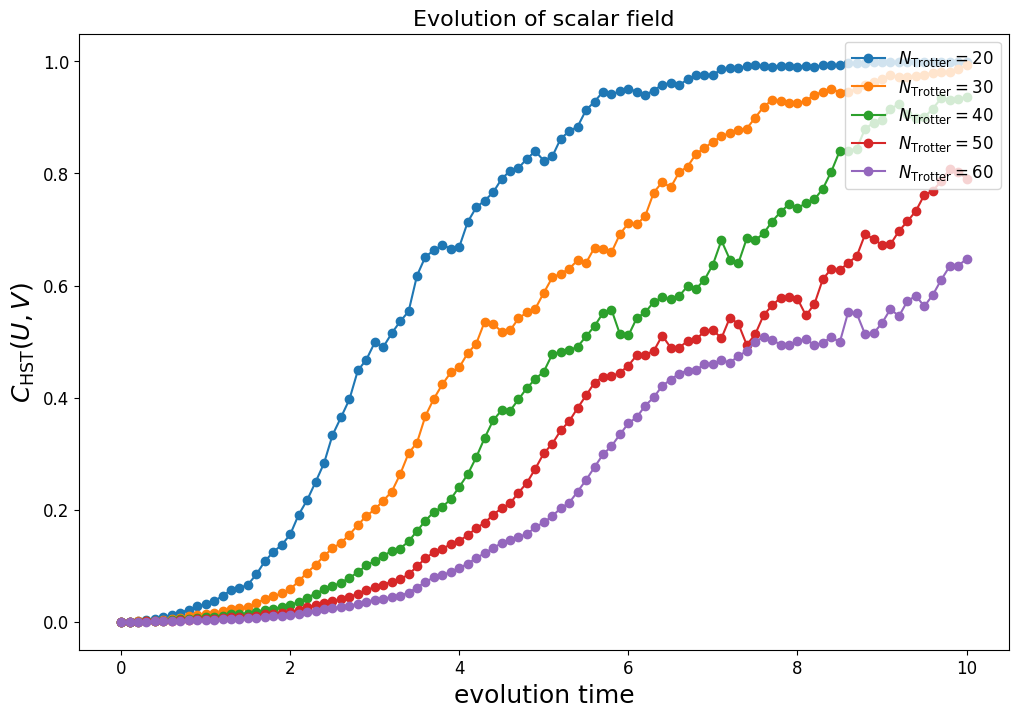

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (12, 8)
for hs_cost, n_trotter in zip(hs_cost_lists, trotter_steps):
    plt.plot(ts, np.array(hs_cost), "-o", label="$N_\\text{Trotter} = $"+ str(n_trotter))

plt.title("Evolution of scalar field", size=16)
plt.xlabel("evolution time", size=18)
plt.ylabel("$C_\\text{HST}(U,V)$", size=18)
plt.tick_params("both", labelsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.show()

It seems like this reduces the Hilbert-Schmidt cost. The inflection point for the cost-function curve moves beyond an evolution time of 5.0 when the number of Trotter steps is 60.

With reference to the devices we defined earlier, however, if we look at the circuit depth we find that

In [ ]:
print(f"The Trotterized circuit with 60 Trotter steps has depth {star_vm.analyze(trotter_state.circuit).depth} on the STAR device")
print(f"The Trotterized circuit with 60 Trotter steps has depth {nisq_vm.analyze(trotter_state.circuit).depth} on the NISQ device")

The Trotterized circuit with 60 Trotter steps has depth 7482 on the STAR device


The Trotterized circuit with 60 Trotter steps has depth 16503 on the NISQ device


### Noisy simulation using QURI VM

This will obviously be difficult to run with any reasonable fidelity. So how do we know if this could even work? Let's try to use a real device again with some finite physical error rate.

In [ ]:
n_trotter = 60
t = 5.0
p_phys_range = np.logspace(-6,-4,30)
trotter_evo_factory = DiscreteScalarFieldTrotterTimeEvoFactory(system, n_trotter)
trotter_circuit = trotter_evo_factory(t)

In [ ]:
fidelity = []
for p_phys in tqdm.tqdm(p_phys_range):
    logical_qubit_count = system.n_state_qubit
    star_property = star_device.generate_device_property(
        logical_qubit_count,
        code_distance=9,
        qec_cycle=TimeValue(1, TimeUnit.MICROSECOND),
        physical_error_rate=p_phys
    )
    star_vm = VM.from_device_prop(star_property)

    fidelity.append(star_vm.analyze(trotter_circuit).fidelity)


  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:02<00:58,  2.02s/it]


  7%|▋         | 2/30 [00:04<00:57,  2.04s/it]


 10%|█         | 3/30 [00:06<00:55,  2.05s/it]


 13%|█▎        | 4/30 [00:08<00:53,  2.06s/it]


 17%|█▋        | 5/30 [00:10<00:51,  2.04s/it]


 20%|██        | 6/30 [00:12<00:48,  2.04s/it]


 23%|██▎       | 7/30 [00:14<00:46,  2.04s/it]


 27%|██▋       | 8/30 [00:16<00:45,  2.05s/it]


 30%|███       | 9/30 [00:18<00:43,  2.05s/it]


 33%|███▎      | 10/30 [00:20<00:40,  2.04s/it]


 37%|███▋      | 11/30 [00:22<00:38,  2.04s/it]


 40%|████      | 12/30 [00:24<00:36,  2.03s/it]


 43%|████▎     | 13/30 [00:26<00:34,  2.03s/it]


 47%|████▋     | 14/30 [00:28<00:32,  2.04s/it]


 50%|█████     | 15/30 [00:30<00:30,  2.04s/it]


 53%|█████▎    | 16/30 [00:32<00:28,  2.04s/it]


 57%|█████▋    | 17/30 [00:34<00:26,  2.05s/it]


 60%|██████    | 18/30 [00:36<00:24,  2.05s/it]


 63%|██████▎   | 19/30 [00:38<00:22,  2.04s/it]


 67%|██████▋   | 20/30 [00:40<00:20,  2.05s/it]


 70%|███████   | 21/30 [00:42<00:18,  2.05s/it]


 73%|███████▎  | 22/30 [00:44<00:16,  2.05s/it]


 77%|███████▋  | 23/30 [00:46<00:14,  2.04s/it]


 80%|████████  | 24/30 [00:49<00:12,  2.04s/it]


 83%|████████▎ | 25/30 [00:51<00:10,  2.04s/it]


 87%|████████▋ | 26/30 [00:53<00:08,  2.05s/it]


 90%|█████████ | 27/30 [00:55<00:06,  2.06s/it]


 93%|█████████▎| 28/30 [00:57<00:04,  2.07s/it]


 97%|█████████▋| 29/30 [00:59<00:02,  2.06s/it]


100%|██████████| 30/30 [01:01<00:00,  2.04s/it]


100%|██████████| 30/30 [01:01<00:00,  2.04s/it]

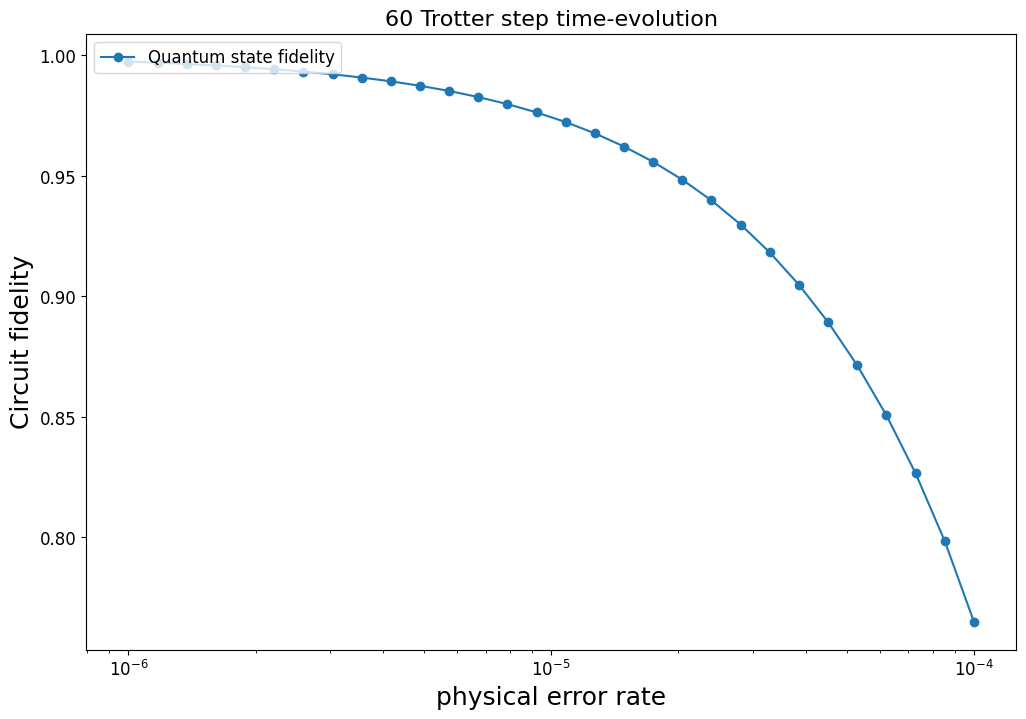

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.semilogx(p_phys_range, np.array(fidelity), "-o", label="Quantum state fidelity")

plt.title("60 Trotter step time-evolution", size=16)
plt.xlabel("physical error rate", size=18)
plt.ylabel("Circuit fidelity", size=18)
plt.tick_params("both", labelsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.show()

With the partial error correction of the STAR architecture it appears that even for relatively high physical error rates we can still expect the quantum circuit to be executable in spite of its depth. Thus we have found a set of parameters where we can execute accurate time evolution using a quantum circuit representation of time-evolution for the scalar-field theory!

## Reference

[1] Andy C. Y. Li, Alexandru Macridin, Stephen Mrenna, Panagiotis Spentzouris. [Simulating scalar field theories on quantum computers with limited resources](https://arxiv.org/pdf/2210.07985)

[2] Alexandru Macridin, Andy C. Y. Li, Stephen Mrenna, Panagiotis Spentzouris. [Bosonic field digitization for quantum computers](https://arxiv.org/pdf/2108.10793)

[3] Yutaro Akahoshi, Kazunori Maruyama, Hirotaka Oshima, Shintaro Sato, Keisuke Fujii. [Partially Fault-tolerant Quantum Computing Architecture with Error-corrected Clifford Gates and Space-time Efficient Analog Rotations](https://arxiv.org/abs/2303.13181)